# Определение возможного согласия на покупку оборудования клиентом

## Модель, прогнозирующая согласие клиента

**Заказчик:** телеком-компания R1

**Входные данные:** информация с характеристиками клиентов; данные изначально разделены на обучающий и тестовый наборы.

**Цель проекта:** разработать модель, предсказывающую вероятность согласия клиента. Если модель покажет, что вероятность высокая, то клиенту позвонят с предложением. Лучшая модель будет опробована и конверсия доведена до разработчика. 

**Задачи проекта:**

- провести исследовательский анализ данных;
- выбрать признаки для обучения моделей;
- обучить разные модели и оценить их качество кросс-валидацией;
- выбрать лучшую модель и проверить ее на тестовой выборке;
- сравнить эффект, который принесет выбранная модель;
- дать рекомендации по дальнейшему развитию данного проекта.

## Вспомогательное

In [1]:
#!pip install scikit-learn
#!pip install pyarrow
#!pip install fastparquet
#!pip install optuna
#!pip install imblearn
#!pip install catboost
#!pip install hyperopt 


In [2]:
import pandas as pd
import numpy as np
from scipy import stats

import os
import json
import warnings
from datetime import date
import re
from numpy import float16


import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import plotly.graph_objects as go
import plotly.io as pio

from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler#, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

import catboost
from catboost import CatBoostClassifier, cv
from catboost.utils import get_roc_curve, Pool

from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline


from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC

from sklearn.metrics import roc_auc_score, matthews_corrcoef, cohen_kappa_score
from sklearn.inspection import permutation_importance


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import optuna
from optuna.samplers import TPESampler

import pickle
from hyperopt import Trials, STATUS_OK, tpe, hp

from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import HistGradientBoostingClassifier as HGBC


### Константы

In [3]:
RANDOM_STATE = RS = 12345 # константа для random_state
CR = '\n'                 # новая строка
N_TRIALS = 50            # количество попыток для Optuna
#TIMEOUT = 300             # максимальный порог времени для Optuna
SCORING = 'roc_auc'            # основная метрика
LOCAL_PATH = 'D:/Hakathon_R1/'
SEED = 50

### Готовое

In [4]:
#Ячейка со списками важных признаков
#Так как лучший результат на подобранных признаках был получен членом нашей команды
#Александрой Саакян, то именно её список и взят основой для дальнейшей работы.
list_sashin = pd.read_csv(LOCAL_PATH + 'column_names.csv' )
list_sashin = list(list_sashin['id'])

list_corr_f = pd.read_csv(LOCAL_PATH +'list_corr_coll.csv')
list_corr_f = list_corr_f['index'].tolist()

imp_features = pd.read_csv(LOCAL_PATH +'imp_features_my.csv')['0'].tolist()
imp_features

# Объединим списки и уберём дубликаты
imp_features += list_sashin# + list_corr_f
imp_features = list(set(list(imp_features)))

#new_train = pd.read_csv(LOCAL_PATH+'dataset.csv')

In [5]:
len(list_sashin)

722

In [6]:
len(imp_features)

731

### Вспомогательные функции 

In [7]:
def df_name(df):
    """
    определение имени таблицы
    """
    return [name for name in globals() if globals()[name] is df][0]

In [8]:
# выделение в тексте
class f:
    BOLD = "\033[1m"
    ITALIC = "\033[3m"
    END = "\033[0m"

In [9]:
def basic_info(df: pd.DataFrame, sample_type='sample', samples=5, describe='all'):
    """
    первичная информация о таблице: info(), sample()/head()/tail(), describe()
    """
    
    # заголовок (имя исследуемого датафрейма)
    
    print('датафрейм - ', df_name)


    # метод info()
    
    print('\n\n--- метод info() ---\n')
    print(df.info())

    
    # несколько случайных записей
    
    print(f'\n\n--- метод {sample_type}({samples}) ---')
    
    if sample_type == 'sample':
        display(df.sample(samples))
    elif sample_type == 'head':
        display(df.head(samples))
    elif sample_type == 'tail':
        display(df.tail(samples))
    else:
        print(f'{sample_type} – недопустимое значение параметра "sample_type" ')
    
    
    # метод describe()
    
    print(f'\n\n--- метод describe({describe}) ---')
    
    if describe=='all' or describe=='numeric':
        try:
            display(df.describe(include=np.number))
        except ValueError:
            pass

    if describe=='all' or describe=='categorical':
        try:
            display(df.describe(exclude=np.number).T)
        except ValueError:
            pass
    
    if describe not in ['numeric','categorical','all']:
        print(f'{describe} – недопустимое значение параметра "describe" ')

### Оформление

In [10]:
# выделение в тексте
class f:
    BOLD = "\033[1m"
    ITALIC = "\033[3m"
    END = "\033[0m"

In [11]:
# оформление графиков по умолчанию

# Matplotlib, Seaborn
sns.set_style('whitegrid', {'axes.facecolor': '0.98', 'grid.color': '0.9', 'axes.edgecolor': '1.0'})
plot_dpi = 150                                        # dpi для рендеринга графиков

# Plotly Graph_Objects
pio.templates['my_theme'] = go.layout.Template(
                                               layout_autosize=True,
                                               # width=900,
                                               layout_height=200,
                                               layout_legend_orientation="h",
                                               layout_margin=dict(t=40, b=40),         # (l=0, r=0, b=0, t=0, pad=0)
                                               layout_template='seaborn',
                                              )
pio.templates.default = 'my_theme'

# цвета, цветовые схемы
my_cmap = LinearSegmentedColormap.from_list('', ['steelblue', 'aliceblue', 'steelblue'])

In [12]:
# оформление Pandas
pd.options.display.max_colwidth = 100
pd.options.display.max_rows = 500
pd.options.display.max_columns = 100
pd.options.display.float_format = '{:.3f}'.format
# pd.options.display.colheader_justify = 'left'

In [14]:
# оформление — скрытие предупреждений
warnings.filterwarnings('ignore')

## Входные данные

### Чтение и проверка входных данных

In [15]:
#data = custom_read_csv('datasets/hotel_train.csv')  # данные для обучения
#data_test = custom_read_csv('datasets/hotel_test.csv')  # данные для проверки

In [16]:
data_descr = pd.read_json(LOCAL_PATH+'features_types.json', orient='index').reset_index()

In [17]:
basic_info(data_descr)

датафрейм -  <function df_name at 0x0000011BB49E65C0>


--- метод info() ---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2776 entries, 0 to 2775
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   2776 non-null   object
 1   0       2776 non-null   object
dtypes: object(2)
memory usage: 43.5+ KB
None


--- метод sample(5) ---


,index,0
2420,campaigns_208_1_sum,numeric
2347,campaigns_135_1_sum,numeric
1583,movix_channels_78_1_sum,numeric
701,markers_723_1_cnt,numeric
256,markers_267_1_cnt,numeric




--- метод describe(all) ---


,count,unique,top,freq
index,2776,2776,markers_0_1_cnt,1
0,2776,3,numeric,2607


In [18]:
data_descr.head()

,index,0
0,markers_0_1_cnt,numeric
1,markers_1_1_cnt,numeric
2,markers_2_1_cnt,numeric
3,markers_3_1_cnt,numeric
4,markers_4_1_cnt,numeric


Таблица содержит информацию о типе столбцов основного датасета.

In [19]:
data_descr.columns

Index(['index', 0], dtype='object')

In [20]:
data_descr[0].unique()

array(['numeric', 'categorical_str', 'categorical_int'], dtype=object)

In [21]:
data_descr[data_descr[0] == 'categorical_int']

,index,0
805,communication_availability_0_1_flg,categorical_int
837,communication_availability_1_1_ctg,categorical_int
839,communication_availability_2_1_flg,categorical_int
842,user_lifetime_1_1_flg,categorical_int
844,communication_availability_3_1_flg,categorical_int
847,materials_details_5_1_flg,categorical_int
849,materials_details_7_1_flg,categorical_int
850,materials_details_8_1_flg,categorical_int
974,communication_availability_4_1_flg,categorical_int
975,communication_availability_5_1_flg,categorical_int


In [22]:
data_descr[data_descr[0] == 'categorical_str'].count()

index    31
0        31
dtype: int64

In [23]:
list_col_str = data_descr[data_descr[0] == 'categorical_str']['index']

In [24]:
data_descr[data_descr[0] == 'categorical_int'].count()

index    138
0        138
dtype: int64

In [25]:
list_col_int = data_descr[data_descr[0] == 'categorical_int']['index']

In [26]:
data_descr[data_descr[0] == 'numeric'].count()

index    2607
0        2607
dtype: int64

In [27]:
list_col_num = data_descr[data_descr[0] == 'numeric']['index']

In [28]:
data_descr.to_csv (LOCAL_PATH +'data_descr.csv', index= False )

In [29]:
data_descr.head()

,index,0
0,markers_0_1_cnt,numeric
1,markers_1_1_cnt,numeric
2,markers_2_1_cnt,numeric
3,markers_3_1_cnt,numeric
4,markers_4_1_cnt,numeric


Итак, у нас 3 неодинаковых по количеству типа признаков. 31 категориальный с описанием, 138 категориальных биномиальных. И больше двух с половиной тысяч числовых.

Числовые данные неплохо группируются по типам:
1. Какого рода информацию они кодируют:
markers
spas_symptoms_agr
payments_details
user_devices
materials_details
arpu
balance_details
charges_details
tariff_plans
plan_costs
charges_details
vas_details
smarttv_age
spas_symptoms_int
area
traffic_details
traffic_details
movix_channels
user_lifetime
info_house
deact_react
issues
online_cinema
save_team_answers
movix_app_visits

2. Какой тип данных (среднее, сумма и т.д.)
На конце
dex
cnt
std
sum
avg
ctg
flg
pct
_dt
num
ean
max
_id
art
min

    

Для дополнительной обработки признаков, которые нужно будет проверять с учётом их количества, зададим списки уникальных значений начала и окончания названия столбца.

Зададим уникальные группы начала файла

In [30]:
col_start = ['markers_', 'spas_symptoms', 'materials_details', 'communication_availability', 'payments_details', 'user_devices',
             'user_lifetime', 'arpu_', 'balance_details', 'charges_details', 'tariff_plans', 'plan_costs', 'vas_details', 
             'social_dem', 'smarttv_age', 'area_', 'user_active', 'traffic_details', 'scheme_types', 'movix_channels',
             'deact_react', 'info_house', 'exist_tariff', 'issues_', 'online_cinema', 'cities_', 'save_team', 'migrant_', 
             'movix_app', 'basic_info', 'type_av', 'agreement_type', 'autopay_', 'campaigns_', 'overdue_payments', 'domru_site']

In [31]:
col_end = ['_dex', '_cnt', '_std', '_sum', '_avg', '_ctg', '_flg', '_pct', '_dt', '_num', '_ean', '_max', '_id', '_art', '_min']

In [32]:
column_list = []

Для проверки признаков группами и группового открытия файла типа parquet создадим функцию фильтрации по началу столбца. 

In [33]:
def filter_by_pattern(df, column_name, pattern):
  return df[df[column_name].apply(lambda x: bool(re.search(pattern+'.*', x)))]

In [34]:
pattern = col_start[2]
pattern

'materials_details'

In [35]:
column_list = filter_by_pattern(data_descr, 'index', pattern)

column_list = pd.Series(column_list['index']).tolist()
#column_list.append('target')

Также создадим функцию группового открытия файла типа parquet:

In [36]:

def read_columns_from_list(column_list, file_name):
    df = pd.read_parquet(columns=column_list, path = LOCAL_PATH+file_name) 
    return df 


Пробное открытие train, по части столбцов.

In [37]:
parquet_name = 'dataset_train.parquet'
part_df_2 = read_columns_from_list(column_list, parquet_name)

In [38]:
part_df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702086 entries, 0 to 702085
Data columns (total 26 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   materials_details_0_1_ctg   702086 non-null  int64  
 1   materials_details_1_1_ctg   702086 non-null  int64  
 2   materials_details_2_1_cnt   121665 non-null  float64
 3   materials_details_3_1_dt    61361 non-null   float64
 4   materials_details_4_1_dt    61361 non-null   float64
 5   materials_details_5_1_flg   702086 non-null  int8   
 6   materials_details_6_1_num   61361 non-null   float64
 7   materials_details_7_1_flg   702086 non-null  int8   
 8   materials_details_8_1_flg   702086 non-null  int8   
 9   materials_details_9_1_flg   702086 non-null  int32  
 10  materials_details_10_1_flg  702086 non-null  int32  
 11  materials_details_11_1_flg  702086 non-null  int32  
 12  materials_details_12_1_flg  702086 non-null  int32  
 13  materials_deta

In [39]:
part_df_2.head()

,materials_details_0_1_ctg,materials_details_1_1_ctg,materials_details_2_1_cnt,materials_details_3_1_dt,materials_details_4_1_dt,materials_details_5_1_flg,materials_details_6_1_num,materials_details_7_1_flg,materials_details_8_1_flg,materials_details_9_1_flg,materials_details_10_1_flg,materials_details_11_1_flg,materials_details_12_1_flg,materials_details_13_1_ctg,materials_details_14_1_ctg,materials_details_15_1_ctg,materials_details_16_1_ctg,materials_details_17_1_cnt,materials_details_18_1_dt,materials_details_19_1_dt,materials_details_20_1_flg,materials_details_21_1_num,materials_details_22_1_flg,materials_details_23_1_flg,materials_details_24_1_cnt,materials_details_25_1_cnt
0,1,1,NaN,NaN,NaN,-1,NaN,-1,-1,-1,-1,-1,-1,1,0,0,NaN,NaN,NaN,NaN,-1,NaN,-1,-1,NaN,NaN
1,1,1,NaN,NaN,NaN,-1,NaN,-1,-1,-1,-1,-1,-1,1,0,0,NaN,NaN,NaN,NaN,-1,NaN,-1,-1,NaN,NaN
2,1,1,NaN,NaN,NaN,-1,NaN,-1,-1,-1,-1,-1,-1,1,0,0,NaN,NaN,NaN,NaN,-1,NaN,-1,-1,NaN,NaN
3,1,1,NaN,NaN,NaN,-1,NaN,-1,-1,-1,-1,-1,-1,1,0,0,NaN,NaN,NaN,NaN,-1,NaN,-1,-1,NaN,NaN
4,1,1,NaN,NaN,NaN,-1,NaN,-1,-1,-1,-1,-1,-1,1,0,0,NaN,NaN,NaN,NaN,-1,NaN,-1,-1,NaN,NaN


In [40]:
part_df_2.describe()

,materials_details_0_1_ctg,materials_details_1_1_ctg,materials_details_2_1_cnt,materials_details_3_1_dt,materials_details_4_1_dt,materials_details_5_1_flg,materials_details_6_1_num,materials_details_7_1_flg,materials_details_8_1_flg,materials_details_9_1_flg,materials_details_10_1_flg,materials_details_11_1_flg,materials_details_12_1_flg,materials_details_13_1_ctg,materials_details_14_1_ctg,materials_details_15_1_ctg,materials_details_16_1_ctg,materials_details_17_1_cnt,materials_details_18_1_dt,materials_details_19_1_dt,materials_details_20_1_flg,materials_details_21_1_num,materials_details_22_1_flg,materials_details_23_1_flg,materials_details_24_1_cnt,materials_details_25_1_cnt
count,702086.000,702086.000,121665.000,61361.000,61361.000,702086.000,61361.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,59761.000,121665.000,52187.000,52187.000,702086.000,52187.000,702086.000,702086.000,121665.000,121665.000
mean,6.786,1.393,0.099,-0.079,-0.082,-0.781,-0.079,-0.794,-0.816,-0.809,-0.752,-0.812,-0.739,7.747,25.870,527.167,0.067,-0.088,-0.049,-0.050,-0.782,-0.048,-0.802,-0.819,0.009,-0.002
std,33.646,5.650,1.017,0.977,0.974,0.512,0.977,0.479,0.413,0.437,0.579,0.426,0.606,32.882,66.034,1266.124,0.997,0.989,0.969,0.969,0.510,0.969,0.456,0.404,1.017,0.996
min,0.000,0.000,-0.870,-2.110,-2.103,-1.000,-2.110,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,0.000,0.000,0.000,-1.542,-0.865,-1.871,-1.824,-1.000,-1.870,-1.000,-1.000,-0.288,-0.326
25%,1.000,1.000,-0.870,-0.704,-0.728,-1.000,-0.703,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,1.000,0.000,0.000,-1.046,-0.865,-0.834,-0.818,-1.000,-0.833,-1.000,-1.000,-0.288,-0.326
50%,1.000,1.000,0.953,0.100,0.106,-1.000,0.100,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,1.000,0.000,0.000,0.608,-0.865,-0.154,-0.177,-1.000,-0.152,-1.000,-1.000,-0.288,-0.326
75%,1.000,1.000,0.953,0.600,0.625,-1.000,0.601,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,1.000,0.000,0.000,0.608,0.775,0.755,0.724,-1.000,0.757,-1.000,-1.000,-0.288,-0.326
max,303.000,86.000,10.069,6.054,6.177,1.000,6.056,1.000,1.000,1.000,1.000,1.000,1.000,248.000,317.000,4998.000,3.090,31.939,8.356,8.542,1.000,8.355,1.000,1.000,13.021,16.681


In [41]:
part_df_2['materials_details_7_1_flg'].value_counts()

materials_details_7_1_flg
-1    580421
 0     98654
 1     23011
Name: count, dtype: int64

In [42]:
part_df_2['materials_details_9_1_flg'].value_counts()
   

materials_details_9_1_flg
-1    580421
 0    108887
 1     12778
Name: count, dtype: int64

In [43]:
part_df_2['materials_details_14_1_ctg'].value_counts()
   

materials_details_14_1_ctg
0      580421
84      46506
246     31605
196     15898
1        7050
104      4529
168      2620
265      2585
247      1418
63       1393
220      1066
113       523
2         491
297       463
85        404
31        359
153       351
232       325
208       303
270       282
142       279
175       276
283       267
55        251
197       242
119       103
248        80
303        69
64         66
226        64
26         56
280        56
3          55
190        54
50         54
71         45
254        44
38         41
105        40
136        36
98         35
92         34
121        34
262        33
266        33
80         33
272        33
177        33
187        31
169        30
298        30
235        30
145        29
215        28
279        27
32         25
217        23
206        23
164        22
210        22
13         22
140        21
259        19
198        18
61         17
78         17
162        16
233        16
313        16
10     

Посмотрим на тепловую карту корреляции признаков. Отберем признаки с корреляцией больше 0.1

In [44]:
#fig, ax = plt.subplots(figsize=(15,7), dpi=plot_dpi)
#dt = part_df_2.corr().abs()
#sns.heatmap(df[(1 > dt) & (dt > 0.1)], annot=True, fmt='.2f', linewidths=0.2);

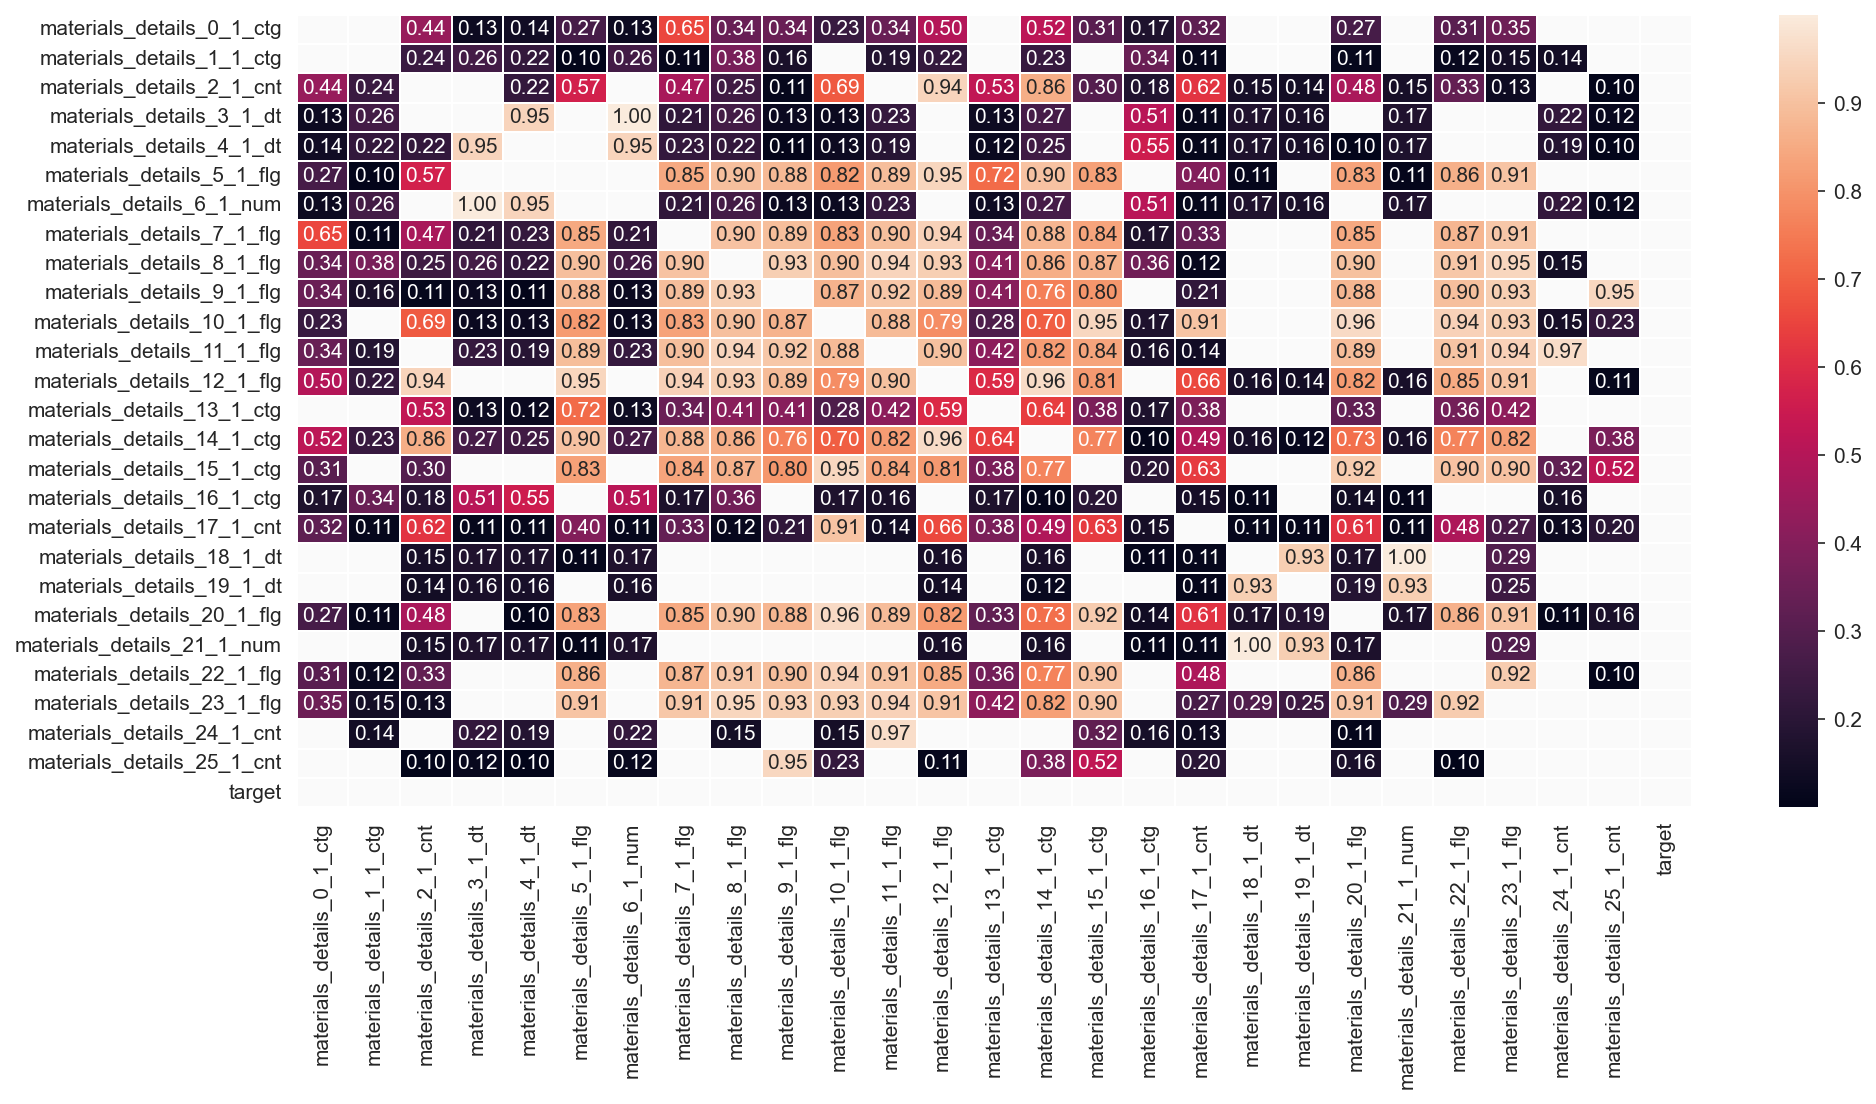

И мы видим, что признаки коррелируют между собой, но не с целевым признаком. Точнее, корреляция с целевым меньше 0.1. Первый взгляд на выделенный целевой признак:

In [45]:
target =   read_columns_from_list(['target'], parquet_name)
target.head()

,target
0,0
1,0
2,1
3,0
4,0


In [46]:
target.mean()

target   0.008
dtype: float64

Меньше процента из тех, с кем связался отдел продвижения делают покупку.

На этом частично открытом файле мы сразу запустили catboost и сделали предсказания - чтобы увидеть уровень показателя без обработки данных. Загрузка показала первый auc roc на тестовой выборке - 0.526. Очень низкий, почти дамми модель. Тем не менее, нам есть от чего отталкиваться.


In [47]:

# predictions_cat_proba.to_csv( LOCAL_PATH+'sub_1_1.csv', index= False)

Посмотрим на распределение важности признаков Catboost по группе materials_details, построив диаграмму.

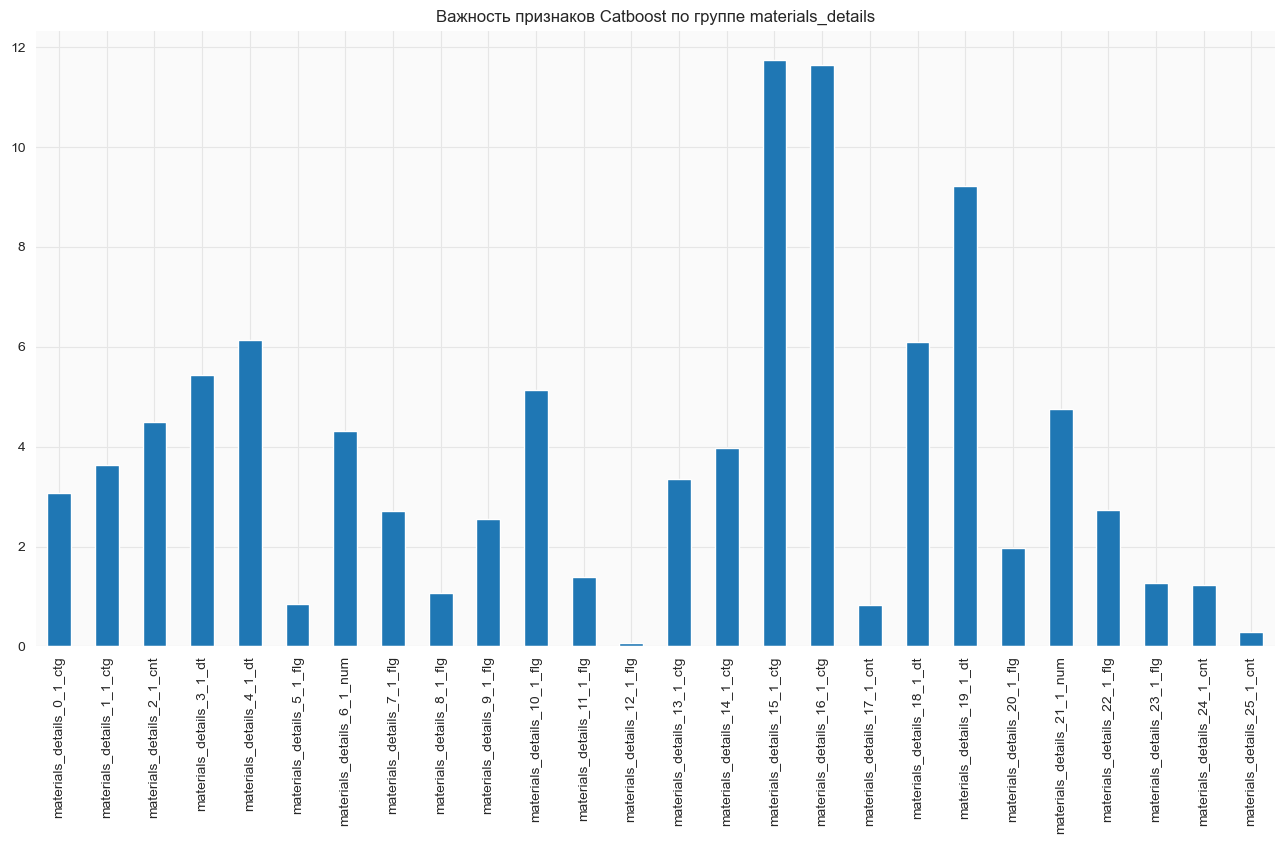

cat_imp = cat_imp.round(3)#[abs(cat_imp)< 0.01].round(3)

cat_imp = pd.DataFrame(cat_imp)
cat_imp.columns = ['cat']
cat_imp.reset_index(inplace = True)

cat_imp

Мы получили три наиболее важных признака, materials_details_16_1_ctg, materials_details_15_1_ctg и materials_details_19_1_dt. Можно ли считать их найденными, если наша модель не справилась с метрикой? Оставим этот вопрос на потом. Проверили выше в таблице, между собой признаки не коррелируют/ корреляция слабая. Забираем их на будущее.
Но сюда не вошли влажки, в них пропуски. Попробуем их 

## Извлечение и обработка данных

Посмотрим на пропуски в файлах. Собственно, идея сравнить колонки в трейне и тесте. И пропуски в них же. 

In [48]:
data_train=pd.read_parquet(LOCAL_PATH+'dataset_train.parquet', engine='fastparquet')


И сразу изменим колонку с неверным типом строчной переменной

In [49]:
data_train['channel_name'] = data_train['channel_name'].astype(int)

В процессе проверки мы нашли наши "тяжелые" float'ы в типе numeric из нашего столбца. Исправляем:

In [50]:
data_train[list_col_num] = data_train[list_col_num].apply(lambda x: x.astype(float16))

Посмотрим, какая красота получилась

In [51]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702086 entries, 0 to 702085
Columns: 2780 entries, id to communication_availability_69_1_flg
dtypes: float16(2607), int32(122), int64(31), int8(19), object(1)
memory usage: 3.9+ GB


In [52]:
data_train.shape

(702086, 2780)

Повтор для тестовой базы

In [53]:
data_test = pd.read_parquet(LOCAL_PATH+'features_oot.parquet', engine='fastparquet')#, pagesize=1000)

In [54]:
data_test['channel_name'] = data_test['channel_name'].astype(int)

In [55]:
data_test[list_col_num] = data_test[list_col_num].apply(lambda x: x.astype(float16))

In [56]:
data_test.shape

(60661, 2779)

In [57]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60661 entries, 0 to 60660
Columns: 2779 entries, id to communication_availability_69_1_flg
dtypes: float16(2607), int32(121), int64(31), int8(19), object(1)
memory usage: 345.5+ MB


Наши датасеты отличаются по числу строк и на одну колонку таргет. Ок. Посмотрим, есть ли пропуски в тесте, что они есть в трэйне- мы уже видели.

In [58]:
(data_train.drop(['target'], axis=1).columns == data_test.columns).all()

True

не сохраняя проверили, совпадают ли все колонки. 
(data_train.drop(['target'], axis=1).columns == data_test.columns).all()
Ответ True - совпадают.

Идентификатор записи, скорее всего, для модели не пригодится. У нас же каждый раз разный набор данных, но пока этот столбец нужен для дополнительного анализа.

 
Функция для проверки пропусков в данных (учитывая количество столбцов, текст по ним не выводился, только список столбцов с пропусками:

In [59]:

def gaps(datafile):
    gap_columns = []
    for column in datafile.columns:
        if datafile[column].count() < datafile.shape[0]:
            gap_columns.append(column)
    
    full_columns = []
    for column in datafile.columns:
        if datafile[column].count() == datafile.shape[0]:
            full_columns.append(column)
    gaps_text = ('Таблица представляет собой массив из ' + str(datafile.shape[1]) 
                 + ' столбцов и '+ str(datafile.shape[0]) + ' строк. ' +
                'Таблица содержит пропуски в столбцах ' + str(gap_columns) + '. Пропуски в ' + str(len(gap_columns)) + ' столбцах из ' + str(datafile.shape[1])
                 +'. Полностью заполнены и не содержат пропусков столбцы ' + str(full_columns) 
                 + ', всего ' + str(len(full_columns)) + ' полностью заполненных столбцов.')
    return gap_columns 


In [60]:
gaps_test = gaps(data_test)
gaps_test

['markers_0_1_cnt',
 'markers_1_1_cnt',
 'markers_2_1_cnt',
 'markers_3_1_cnt',
 'markers_4_1_cnt',
 'markers_5_1_cnt',
 'markers_6_1_cnt',
 'markers_7_1_cnt',
 'markers_8_1_cnt',
 'markers_9_1_cnt',
 'markers_10_1_cnt',
 'markers_11_1_cnt',
 'markers_12_1_cnt',
 'markers_13_1_cnt',
 'markers_14_1_cnt',
 'markers_15_1_cnt',
 'markers_16_1_cnt',
 'markers_17_1_cnt',
 'markers_18_1_cnt',
 'markers_19_1_cnt',
 'markers_20_1_cnt',
 'markers_21_1_cnt',
 'markers_22_1_cnt',
 'markers_23_1_cnt',
 'markers_24_1_cnt',
 'markers_25_1_cnt',
 'markers_26_1_cnt',
 'markers_27_1_cnt',
 'markers_28_1_cnt',
 'markers_29_1_cnt',
 'markers_30_1_cnt',
 'markers_31_1_cnt',
 'markers_32_1_cnt',
 'markers_33_1_cnt',
 'markers_34_1_cnt',
 'markers_35_1_cnt',
 'markers_36_1_cnt',
 'markers_37_1_cnt',
 'markers_38_1_cnt',
 'markers_39_1_cnt',
 'markers_40_1_cnt',
 'markers_41_1_cnt',
 'markers_42_1_cnt',
 'markers_43_1_cnt',
 'markers_44_1_cnt',
 'markers_45_1_cnt',
 'markers_46_1_cnt',
 'markers_47_1_cnt',
 '

In [61]:
df_train = data_train.drop(gaps_test, axis=1)
df_test = data_test.drop(gaps_test, axis=1)

Посмотрим, есть ли дополнительные незаполненные столбцы в трэйне

In [62]:
gaps_train = gaps(df_train)
gaps_train

[]

Нет. Незаполненные столбцы в тесте и трэйне не отличаются.

Взглянем на структуру выброшенного массива

In [63]:
data_train[gaps_test].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702086 entries, 0 to 702085
Columns: 2576 entries, markers_0_1_cnt to markers_945_1_cnt
dtypes: float16(2576)
memory usage: 3.4 GB


In [64]:
data_train[gaps_test].shape

(702086, 2576)

2576 столбцов, ого, мы почти всё выбросили, так не годится. Попробуем заполнить.

## Исследовательский анализ данных

Сбалансированность датасета по целевому признаку

In [65]:
data_train.target.value_counts()

target
0    696617
1      5469
Name: count, dtype: int64

Средняя доля покупок: 0.8%.

Есть дисбаланс целевого признака, при создании моделей необходимо это учесть.

In [66]:
df_train.columns

Index(['id', 'period', 'channel_name', 'target', 'user_devices_0_1_cnt',
       'user_devices_1_1_cnt', 'user_devices_2_1_cnt', 'user_devices_3_1_cnt',
       'user_devices_4_1_cnt', 'user_devices_5_1_cnt',
       ...
       'autopay_1_1_flg', 'autopay_3_1_flg',
       'communication_availability_67_1_flg', 'social_dem_1_0_flg',
       'social_dem_2_0_flg', 'social_dem_3_0_flg', 'social_dem_4_0_flg',
       'user_active_35_1_flg', 'tariff_plans_26_src_id',
       'communication_availability_69_1_flg'],
      dtype='object', length=204)

In [67]:
df_train['period'].value_counts()


period
202210    247831
202211    101360
202212     71449
202208     59506
202207     50593
202203     29917
202201     27248
202205     26423
202202     25315
202209     20993
202206     20747
202204     20704
Name: count, dtype: int64

У нас собраны данные за 2022 год. Посмотрим на распределение данных.

In [68]:
df_train['period']=df_train['period']-202200

In [69]:
df_test['period']=df_test['period']-202200

In [70]:
# временная таблица без лишних полей

df = df_train[['period', 'target']]



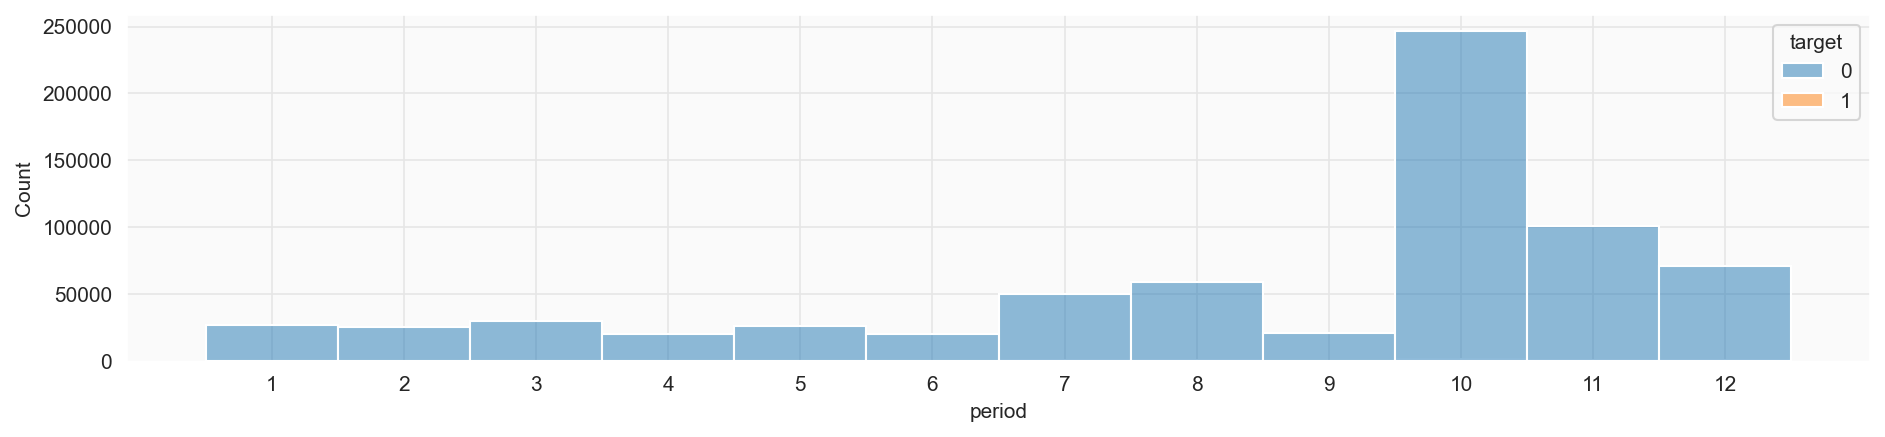

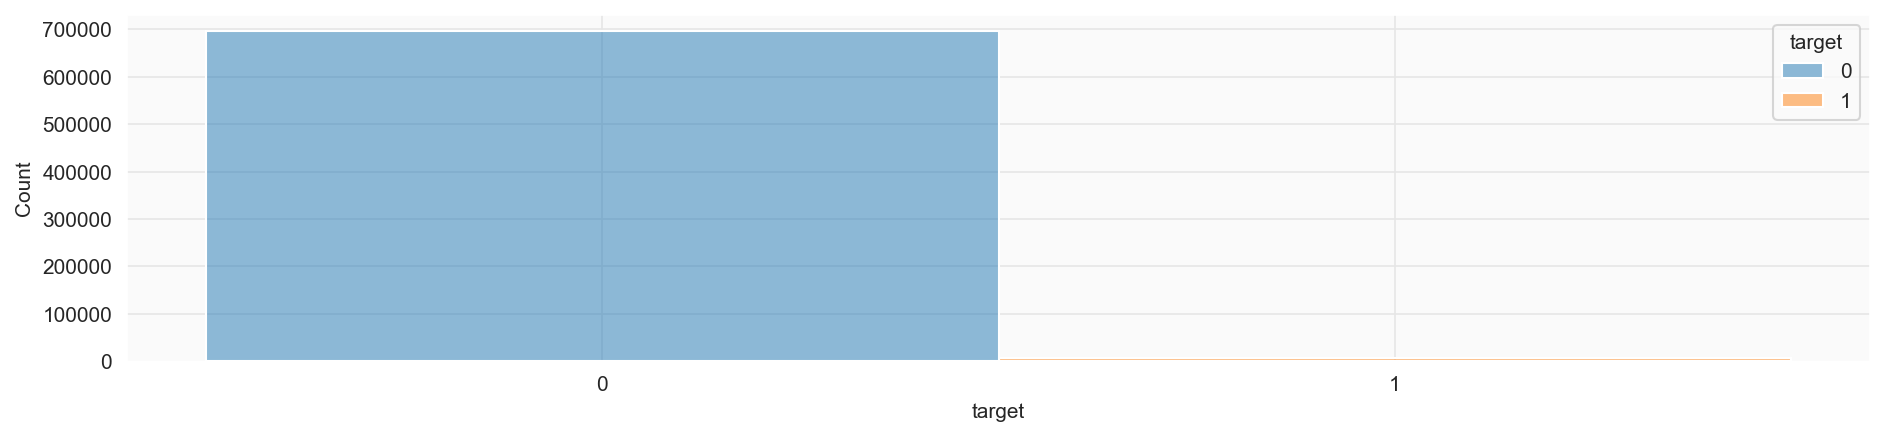

In [71]:
for column in df.columns:
    
    # подбор количества корзин для лучшего восприятия
    discrete_ = True if df[column].nunique() < 60 else False
    
    fig, ax = plt.subplots(figsize=(15,3), dpi=plot_dpi)
    sns.histplot(x=df[column], hue=df.target, bins=20, discrete=discrete_)
    
    if df[column].nunique() < 60:
        ax.set_xticks(df[column].unique());

In [72]:
df_1 = df[df['target']>0]


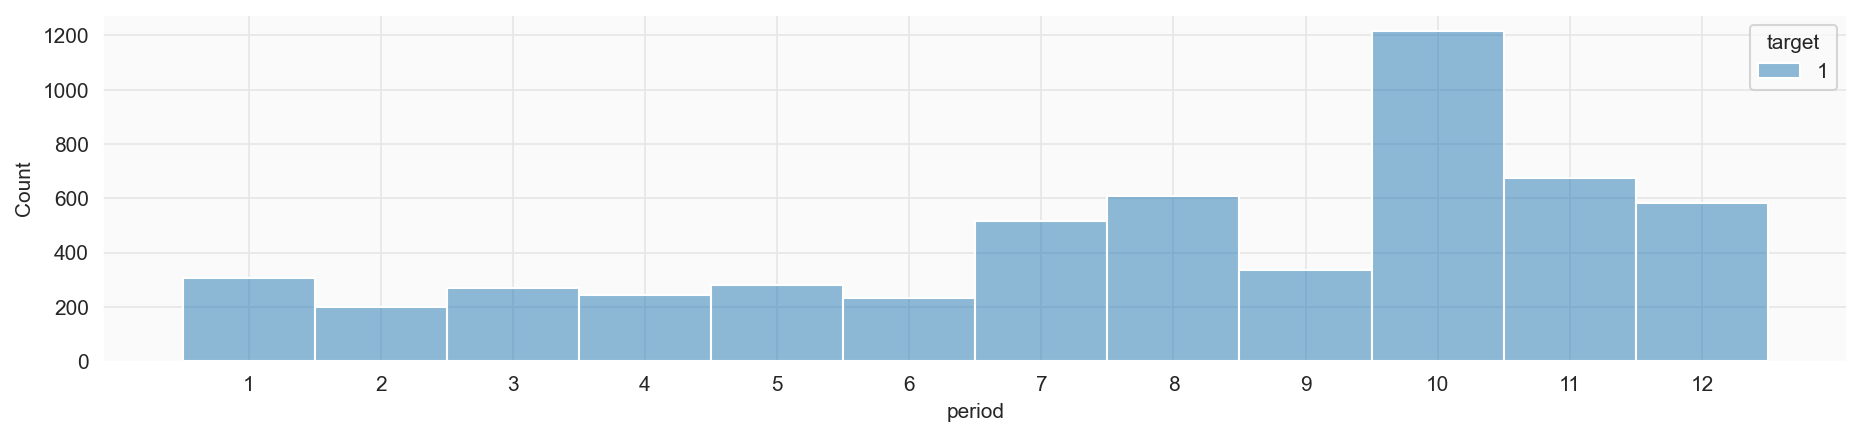

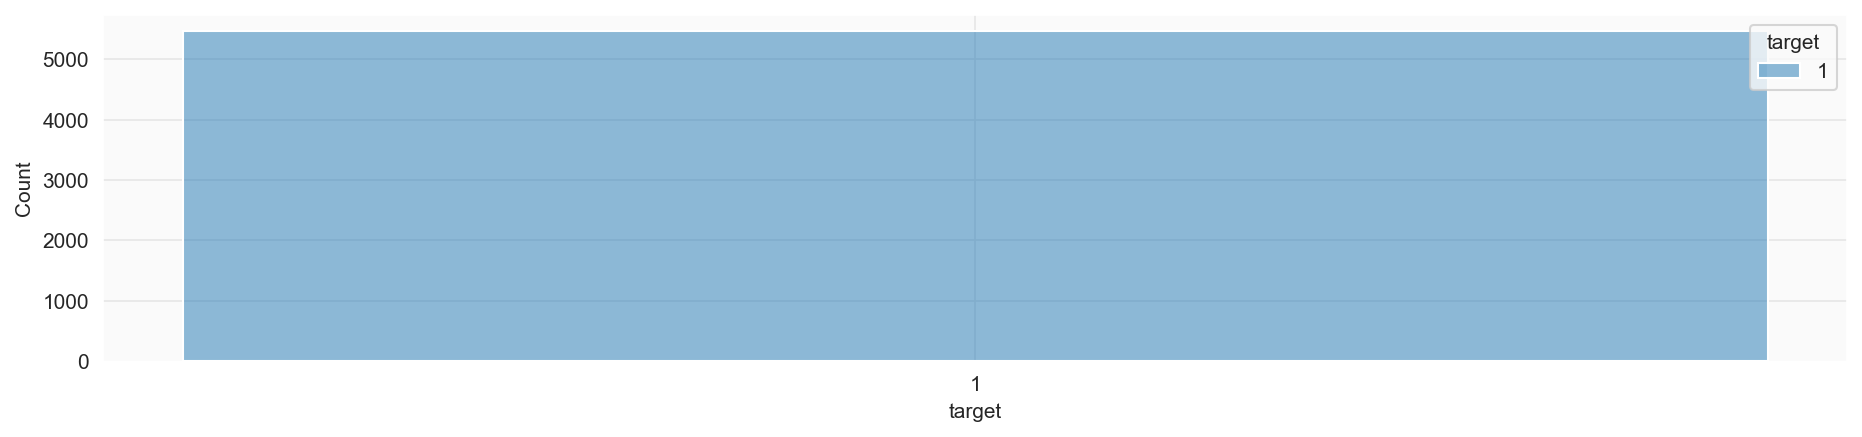

In [73]:
for column in df.columns:
    
    # подбор количества корзин для лучшего восприятия
    discrete_ = True if df_1[column].nunique() < 60 else False
    
    fig, ax = plt.subplots(figsize=(15,3), dpi=plot_dpi)
    sns.histplot(x=df_1[column], hue=df_1.target, bins=20, discrete=discrete_)
    
    if df_1[column].nunique() < 60:
        ax.set_xticks(df_1[column].unique());

В последнем квартале отдел продаж явно погнался за выполнением плана. А может быть, подключили data science? Нет, вряд ли тогда, процент продаж бы возрос. 
Ну что же, по тому, насколько линия согласий повторяет число окученных клиентов ясно, что емкость этого рынка ещё большая.
Интересно, а процент согласий меняется по месяцам?

In [74]:
df[['period', 'target']]


,period,target
0,8,0
1,10,0
2,10,1
3,12,0
4,11,0
...,...,...
702081,9,0
702082,1,0
702083,3,0
702084,1,0


In [75]:
df.groupby('period')['target'].sum()/df.groupby('period')['target'].count()*100

period
1    1.127
2    0.782
3    0.902
4    1.183
5    1.067
6    1.123
7    1.018
8    1.025
9    1.601
10   0.491
11   0.667
12   0.813
Name: target, dtype: float64

Все-таки картина не настолько радужная, при увеличении охвата процент согласий падает. Да, без дата-сайенса не обойтись.

Посмотрим, как разделяется результат по каналам продажи. Мы помним, что запрос был по 3 каналу.

In [76]:
# временная таблица без лишних полей

df = df_train[['period', 'target', 'channel_name']]

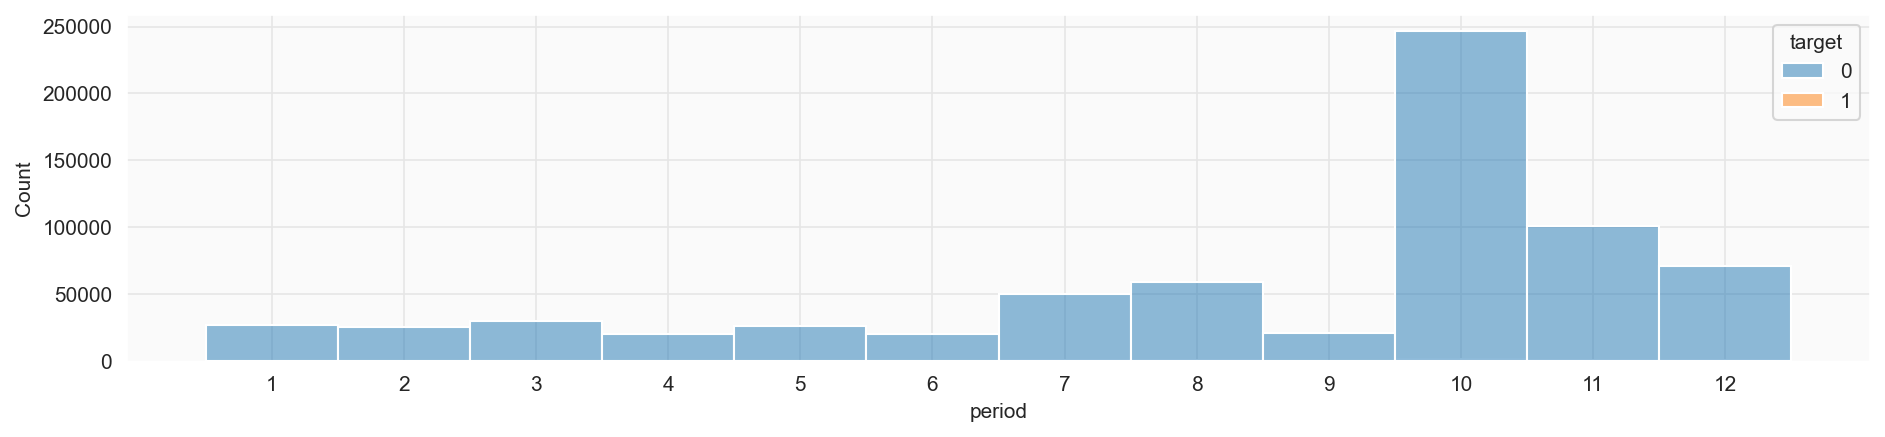

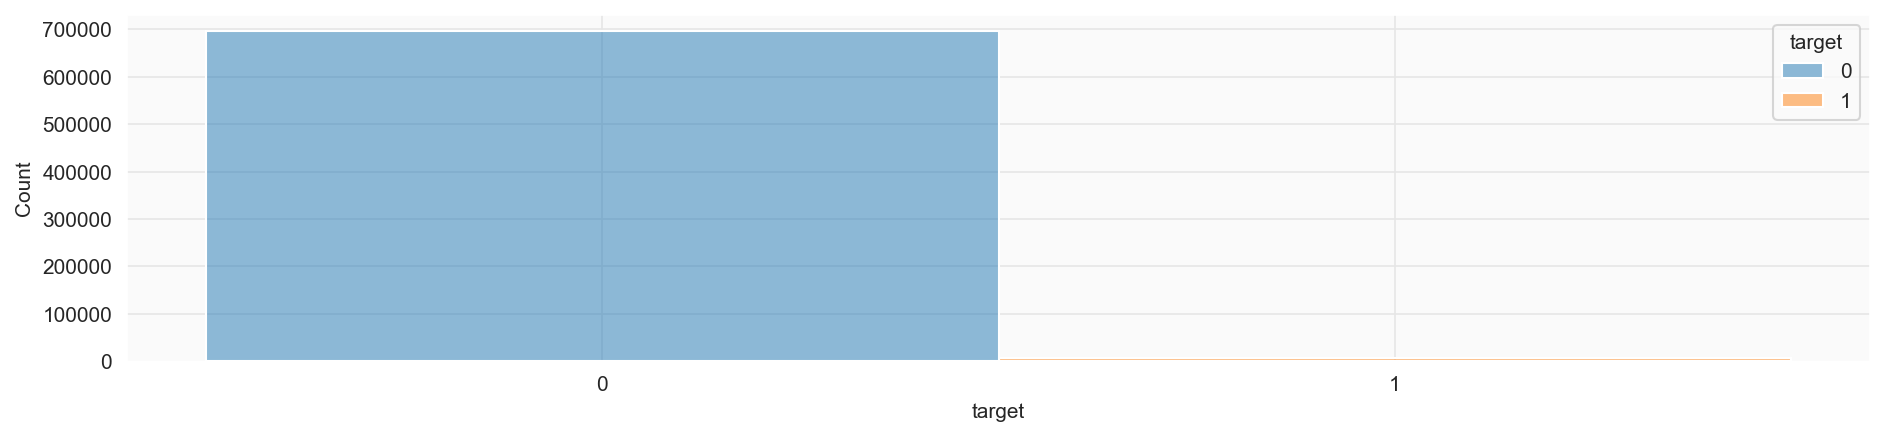

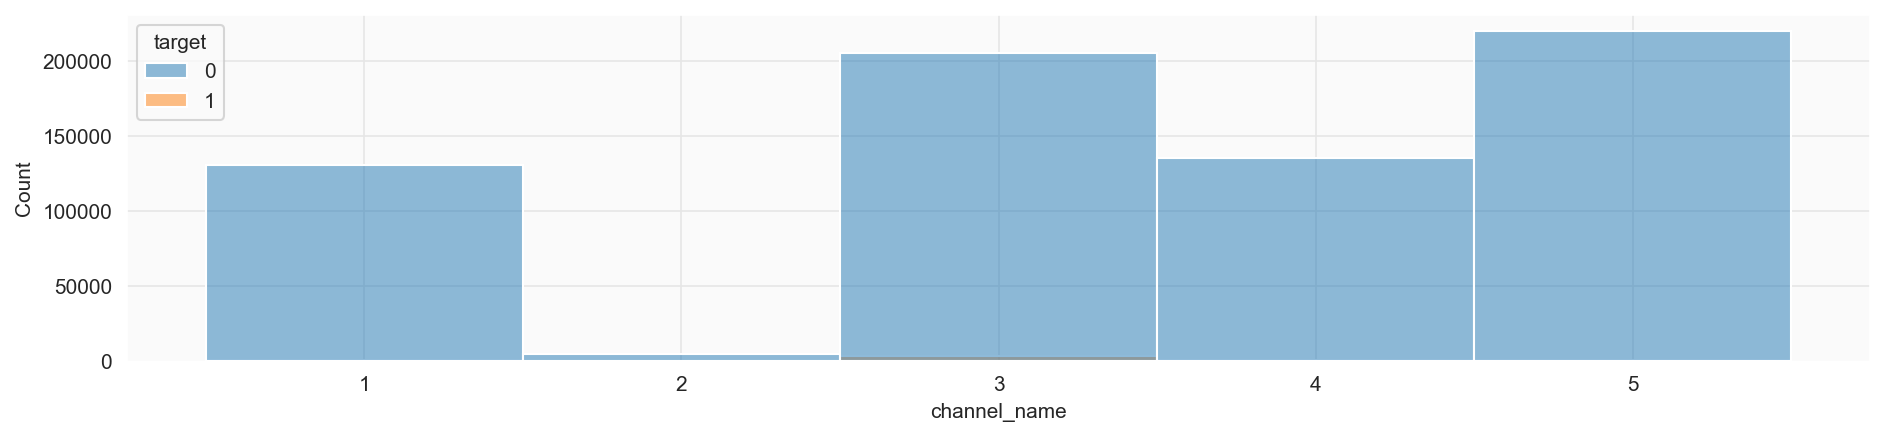

In [77]:
for column in df.columns:
    
    # подбор количества корзин для лучшего восприятия
    discrete_ = True if df[column].nunique() < 60 else False
    
    fig, ax = plt.subplots(figsize=(15,3), dpi=plot_dpi)
    sns.histplot(x=df[column], hue=df.target, bins=20, discrete=discrete_)
    
    if df[column].nunique() < 60:
        ax.set_xticks(df[column].unique());

Лидирует по числу контактов с клиентом пятый канал, но третий его явно догоняет.

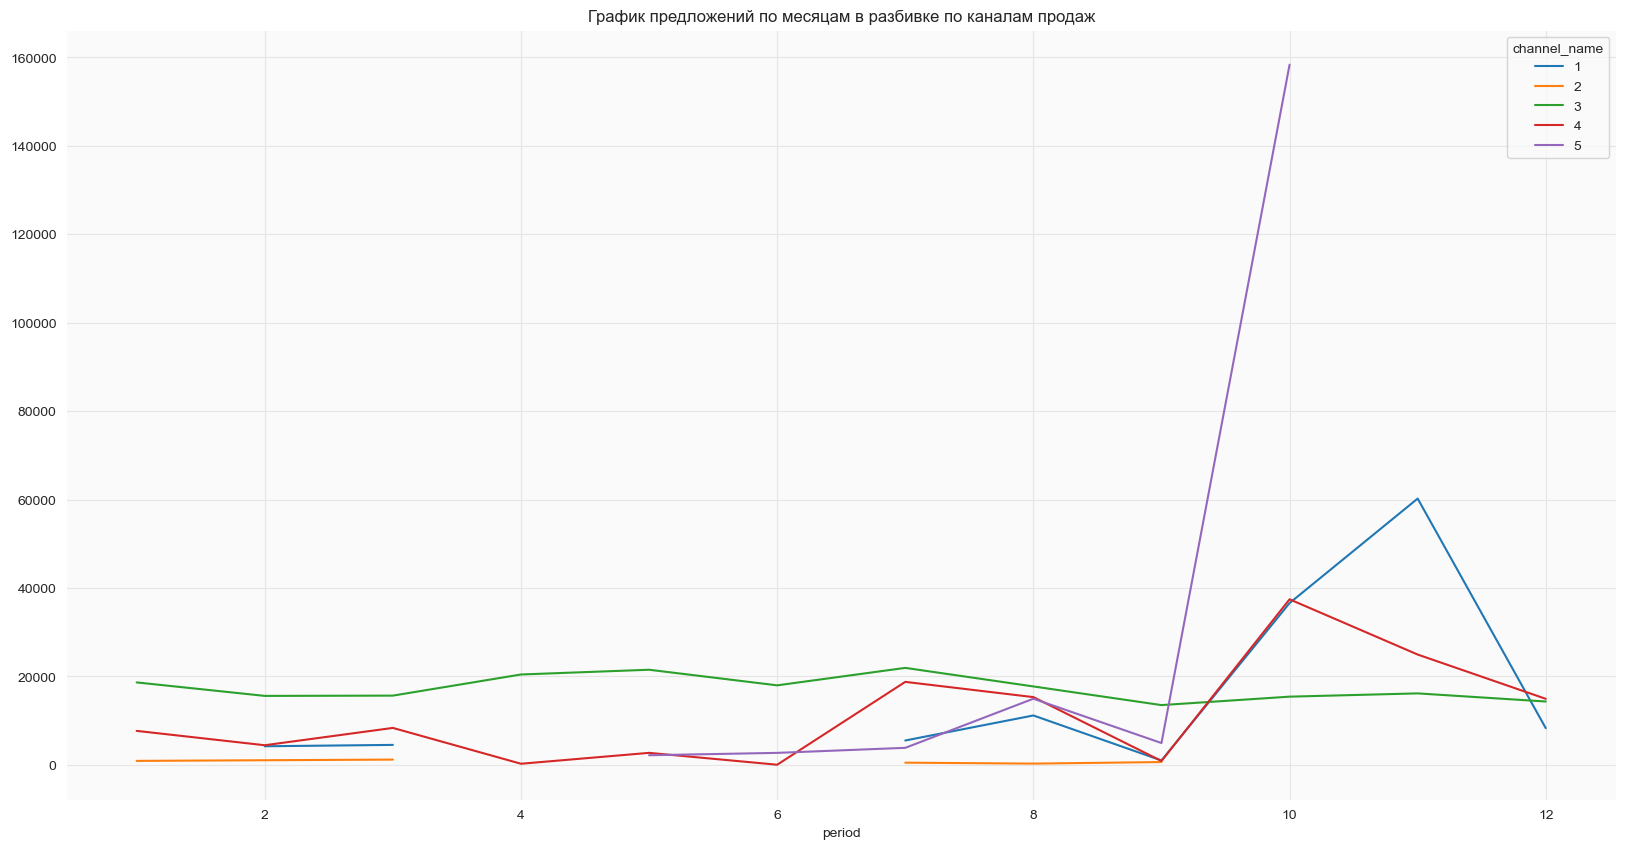

In [78]:
df.groupby(['period', 'channel_name'])['target'].count().unstack('channel_name').plot( figsize = (20, 10))

plt.title('График предложений по месяцам в разбивке по каналам продаж')
plt.show()

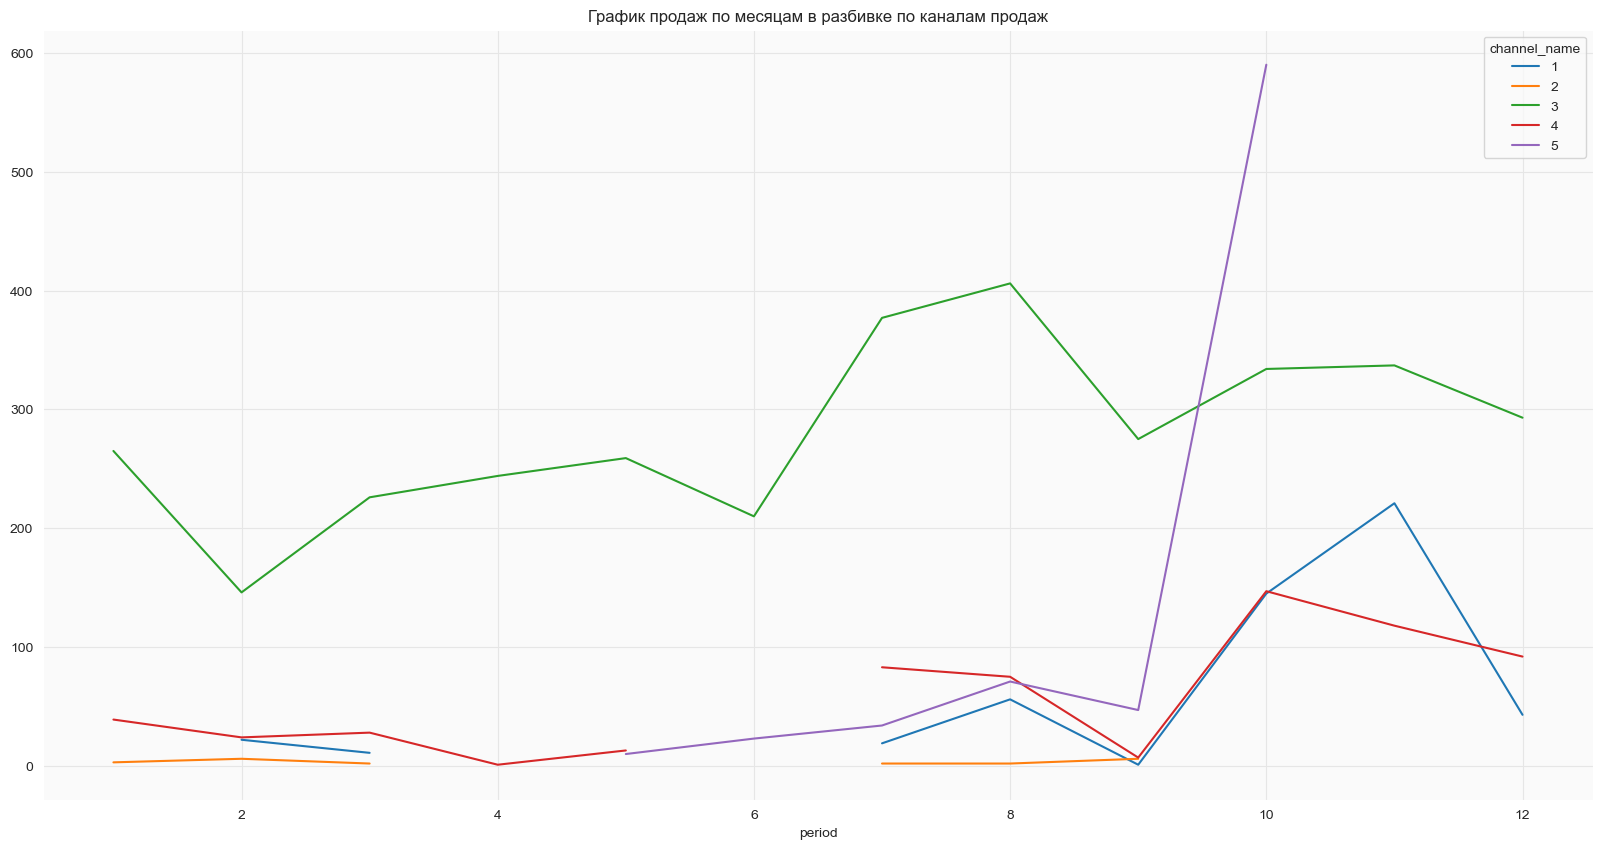

In [79]:
df[df['target']>0].groupby(['period', 'channel_name'])['target'].count().unstack('channel_name').plot( figsize = (20, 10))

plt.title('График продаж по месяцам в разбивке по каналам продаж')
plt.show()

Мы видим, что повышенный охват пользователей производился по пятому каналу. Каналы 1 и 2 задействуются не каждый месяц. А канал 4, хоть и окучивается каждый месяц, имеет разрыв в мае - июне. Интересно, а конверсия по каналам отличается? Проверим

In [80]:
data_pivot = df.pivot_table(index=[ 'channel_name', 'period'], values='target', aggfunc='mean')

In [81]:
data_pivot

target
channel_name period        
1            2        0.005
             3        0.002
             7        0.003
             8        0.005
             9        0.001
             10       0.004
             11       0.004
             12       0.005
2            1        0.003
             2        0.006
             3        0.002
             7        0.004
             8        0.007
             9        0.009
3            1        0.014
             2        0.009
             3        0.014
             4        0.012
             5        0.012
             6        0.012
             7        0.017
             8        0.023
             9        0.020
             10       0.022
             11       0.021
             12       0.020
4            1        0.005
             2        0.005
             3        0.003
             4        0.004
             5        0.005
             6        0.000
             7        0.004
             8        0.005
             9        0.008
             10       0.004
             11       0.005
             12       0.006
5            3        0.018
             5        0.005
             6        0.008
             7        0.009
             8        0.005
             9        0.010
             10       0.004
             12       0.005

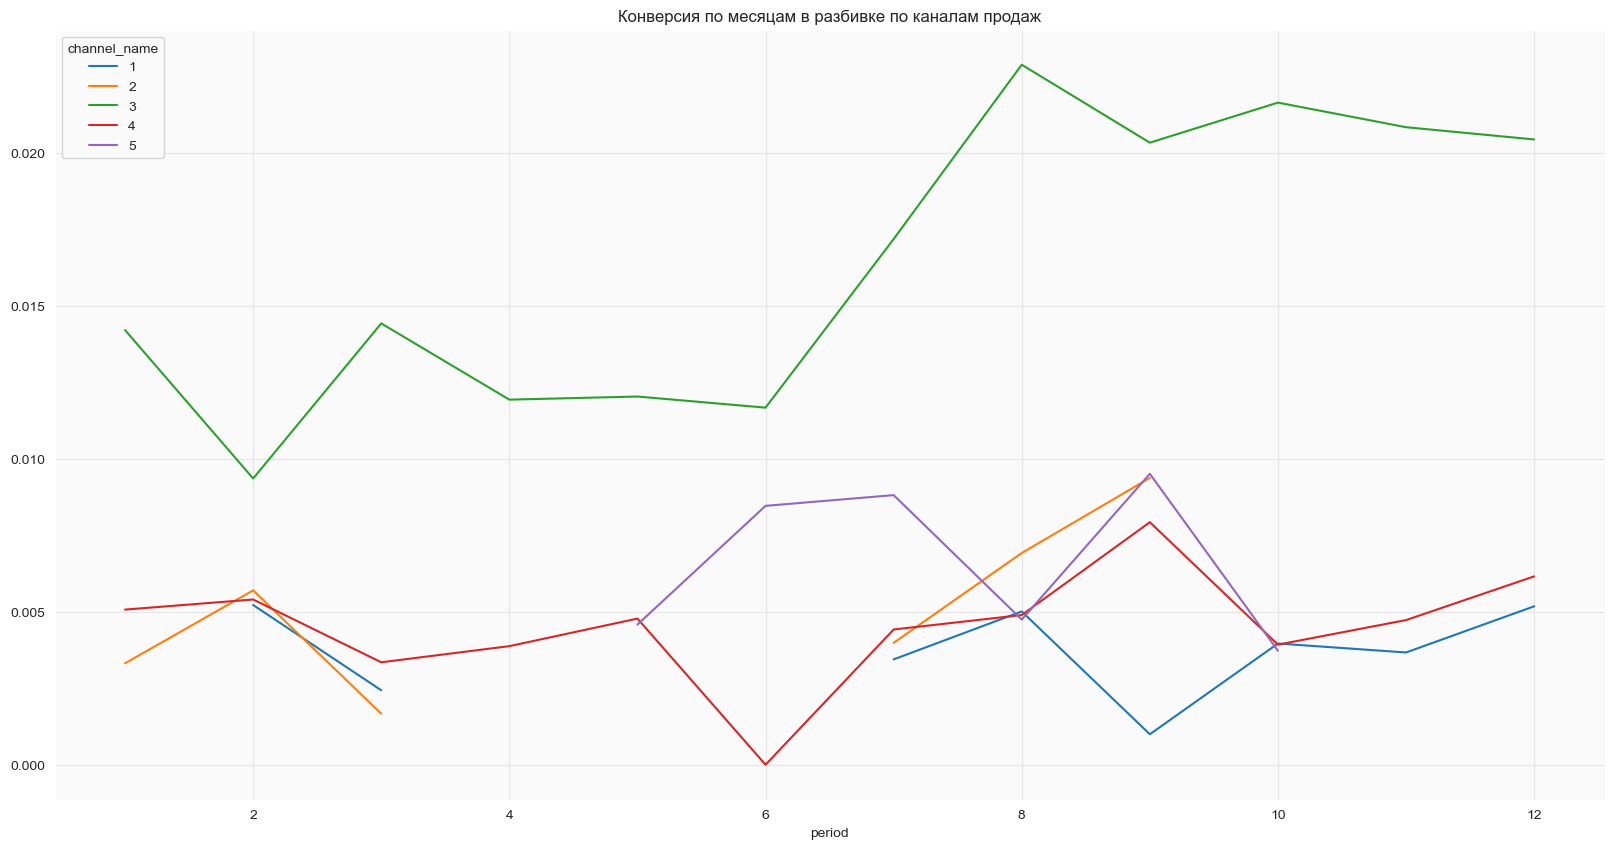

In [82]:
df.groupby(['period', 'channel_name'])['target'].mean().unstack('channel_name').plot( figsize = (20, 10))

plt.title('Конверсия по месяцам в разбивке по каналам продаж')
plt.show()

Да, здесь становится понятно, что третий канал имеет шансы на успех. Неснижаемая, и даже превышающая 0.02 конверсия при постоянном охвате на уровне примерно 20 тысяч контактов. Здесь явно есть, что ещё поискать. Большой охват канала 5 вызвал спад конверсии.

Хорошо, перейдём к поискам того, что может улучшить конверсию.

Теперь посмотрим, есть ли корреляция с таргетом 

In [83]:
#list_corr_f = df_train.corr('spearman').target.to_frame().drop('target').abs().sort_values('target', ascending=False)

In [84]:
#list_corr_f

Прямой корреляции нет, но есть признаки, которые чуть больше связаны, чем другие. Те, что больше пяти промилле не будем выкидывать из расчета.

In [85]:
#list_corr_f.to_csv (LOCAL_PATH +'list_corr_f.csv', index= False )

Код долгий, сохранили в датафрэйм и достали обратно (как получили - выше под комментом)

In [86]:
list_corr_f = pd.read_csv(LOCAL_PATH +'list_corr_f.csv')

In [87]:
list_corr_f 

,target
0,0.034
1,0.029
2,0.029
3,0.029
4,0.028
5,0.027
6,0.026
7,0.026
8,0.024
9,0.024


Посмотрим на нечисловые признаки

In [88]:
data_train[list_col_str]

,materials_details_0_1_ctg,materials_details_1_1_ctg,user_lifetime_0_1_ctg,tariff_plans_12_1_ctg,communication_availability_32_1_ctg,tariff_plans_14_1_ctg,user_active_2_0_ctg,deact_react_2_1_ctg,tariff_plans_16_1_ctg,deact_react_5_1_ctg,deact_react_7_1_ctg,tariff_plans_18_1_ctg,deact_react_10_1_ctg,deact_react_12_1_ctg,tariff_plans_23_1_ctg,deact_react_15_1_ctg,materials_details_13_1_ctg,cities_0_0_ctg,cities_1_0_ctg,materials_details_14_1_ctg,materials_details_15_1_ctg,info_house_10_0_ctg,type_av_100_0_1_ctg,agreement_type_0_0_ctg,autopay_0_0_ctg,autopay_8_0_ctg,autopay_9_0_ctg,area_1_0_ctg,cities_2_0_ctg,communication_availability_68_1_ctg,tariff_plans_25_1_ctg
0,1,1,0,45,3,28,1,0,423,0,0,4055,0,0,310,0,1,5,34,0,0,92648,2,9,0,0,0,3,52,4,36
1,1,1,0,45,4,28,2,0,423,0,0,4055,0,0,310,0,1,5,34,0,0,386575,2,9,0,0,0,3,52,0,36
2,1,1,0,45,3,28,1,0,423,0,0,3755,0,0,310,0,1,5,34,0,0,457298,2,9,0,0,0,0,52,0,36
3,1,1,0,45,4,28,1,0,423,0,0,3637,0,0,287,0,1,5,34,0,0,54985,2,9,0,0,0,3,52,0,36
4,1,1,0,45,3,28,1,0,423,0,0,2601,0,0,320,0,1,5,34,0,0,624960,2,9,0,0,0,3,52,0,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702081,1,1,13,45,1,28,1,0,423,0,5,1858,6,0,215,0,1,4,26,0,0,197054,3,3,0,0,0,0,36,0,36
702082,1,1,0,45,0,28,2,0,423,0,0,5243,0,0,215,0,1,4,26,0,0,600926,3,3,5,2,2,3,36,0,36
702083,1,1,0,45,2,28,2,0,1474,0,0,2204,0,0,215,0,1,4,26,0,0,122718,2,7,0,0,0,0,36,0,36
702084,1,1,0,45,0,28,1,0,423,0,0,3390,0,0,268,0,1,4,26,0,0,557705,3,7,0,0,0,0,36,0,36


In [89]:
data_train.shape

(702086, 2780)

In [90]:
data_train[list_col_str].describe()

,materials_details_0_1_ctg,materials_details_1_1_ctg,user_lifetime_0_1_ctg,tariff_plans_12_1_ctg,communication_availability_32_1_ctg,tariff_plans_14_1_ctg,user_active_2_0_ctg,deact_react_2_1_ctg,tariff_plans_16_1_ctg,deact_react_5_1_ctg,deact_react_7_1_ctg,tariff_plans_18_1_ctg,deact_react_10_1_ctg,deact_react_12_1_ctg,tariff_plans_23_1_ctg,deact_react_15_1_ctg,materials_details_13_1_ctg,cities_0_0_ctg,cities_1_0_ctg,materials_details_14_1_ctg,materials_details_15_1_ctg,info_house_10_0_ctg,type_av_100_0_1_ctg,agreement_type_0_0_ctg,autopay_0_0_ctg,autopay_8_0_ctg,autopay_9_0_ctg,area_1_0_ctg,cities_2_0_ctg,communication_availability_68_1_ctg,tariff_plans_25_1_ctg
count,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000
mean,6.786,1.393,3.501,47.845,2.240,28.001,1.489,0.023,734.546,0.039,0.164,2923.679,0.219,0.018,303.597,0.020,7.747,2.985,18.795,25.870,527.167,346774.442,2.141,6.029,0.669,0.303,0.299,1.846,28.153,0.132,37.107
std,33.646,5.650,5.264,18.214,1.196,0.153,0.528,0.291,518.923,0.460,0.862,1201.666,1.087,0.292,234.682,0.305,32.882,1.507,10.339,66.034,1266.124,203236.237,0.640,1.889,1.685,0.710,0.703,1.363,15.013,0.693,10.943
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,1.000,1.000,0.000,45.000,1.000,28.000,1.000,0.000,423.000,0.000,0.000,1887.000,0.000,0.000,215.000,0.000,1.000,2.000,9.000,0.000,0.000,170930.250,2.000,3.000,0.000,0.000,0.000,0.000,15.000,0.000,36.000
50%,1.000,1.000,0.000,45.000,2.000,28.000,2.000,0.000,423.000,0.000,0.000,2669.000,0.000,0.000,215.000,0.000,1.000,3.000,22.000,0.000,0.000,346507.500,2.000,7.000,0.000,0.000,0.000,3.000,31.000,0.000,36.000
75%,1.000,1.000,8.000,45.000,3.000,28.000,2.000,0.000,1091.000,0.000,0.000,3872.000,0.000,0.000,215.000,0.000,1.000,4.000,26.000,0.000,0.000,522426.750,2.000,7.000,0.000,0.000,0.000,3.000,36.000,0.000,36.000
max,303.000,86.000,21.000,244.000,4.000,32.000,2.000,6.000,2124.000,7.000,6.000,5664.000,6.000,7.000,1190.000,6.000,248.000,5.000,37.000,317.000,4998.000,698903.000,4.000,9.000,7.000,2.000,2.000,3.000,57.000,5.000,197.000


In [91]:
data_train[list_col_str].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702086 entries, 0 to 702085
Data columns (total 31 columns):
 #   Column                               Non-Null Count   Dtype
---  ------                               --------------   -----
 0   materials_details_0_1_ctg            702086 non-null  int64
 1   materials_details_1_1_ctg            702086 non-null  int64
 2   user_lifetime_0_1_ctg                702086 non-null  int64
 3   tariff_plans_12_1_ctg                702086 non-null  int64
 4   communication_availability_32_1_ctg  702086 non-null  int64
 5   tariff_plans_14_1_ctg                702086 non-null  int64
 6   user_active_2_0_ctg                  702086 non-null  int64
 7   deact_react_2_1_ctg                  702086 non-null  int64
 8   tariff_plans_16_1_ctg                702086 non-null  int64
 9   deact_react_5_1_ctg                  702086 non-null  int64
 10  deact_react_7_1_ctg                  702086 non-null  int64
 11  tariff_plans_18_1_ctg                70

Так, формально это не категориальные признаки, так как выражены цифрами. Данные только int. В том, что касается тарифа - явно какие-то признаки тарифных планов, особенно числа в десятках тысяч. Есть признаки, касающиеся домов. 

In [92]:
data_train['tariff_plans_12_1_ctg'].unique()

array([ 45, 222,  84, 179, 165, 105,  65, 225, 193, 243,  86,  67,  10,
        58, 239, 234, 155,  63,  78,  64, 180, 208, 136,  23, 170, 135,
       106,  92,  90,  89, 139, 103, 169, 206, 168, 150, 107,  85,  99,
       141, 158,  87, 219, 109, 108, 224,  47, 112, 147,  79,  25, 213,
       167, 117,  24,  16, 140, 102, 104,  88, 162, 111,  38,  97,  95,
        28,  27, 149, 172, 178, 209, 177, 236, 148, 221, 151, 163,  37,
       227,  12,  15,  22, 218, 223, 115,   6, 185, 212,  76,  94, 229,
       101,  82, 138, 137,  72, 152, 210, 110,  66,  19, 176,  14,  49,
       181, 231,  11, 142,  48, 166, 156,   7, 186,  74,   5,  43,  68,
        39, 129, 230,  33, 195,  50, 238,  59, 116,  40, 130, 184,  98,
       200, 183, 125, 196, 175, 220, 211, 126,  71,  52, 215,  73, 207,
       214,  41,  51, 241,  96, 205, 157, 174, 217, 124, 235,  18, 194,
        35, 144, 145, 242,  30, 100,  57, 127,  46, 226, 237,  77, 190,
         1,  93, 154, 191, 122, 182,  61, 153, 203, 171,  81,  4

In [93]:
data_train['tariff_plans_14_1_ctg'].unique()

array([28, 31, 30, 29, 11, 15,  6,  4, 10,  3, 26, 20, 21, 27, 23, 19, 17,
        1, 13,  7,  2, 24,  8,  5, 22, 12, 32, 18,  0, 14], dtype=int64)

In [94]:
data_train[list_col_int].describe()

,communication_availability_0_1_flg,communication_availability_1_1_ctg,communication_availability_2_1_flg,user_lifetime_1_1_flg,communication_availability_3_1_flg,materials_details_5_1_flg,materials_details_7_1_flg,materials_details_8_1_flg,communication_availability_4_1_flg,communication_availability_5_1_flg,communication_availability_6_1_flg,social_dem_0_0_flg,communication_availability_7_1_ctg,communication_availability_8_1_flg,communication_availability_9_1_flg,communication_availability_10_1_ctg,communication_availability_11_1_flg,communication_availability_12_1_flg,communication_availability_13_1_flg,communication_availability_14_1_flg,communication_availability_15_1_flg,communication_availability_16_1_flg,communication_availability_17_1_flg,communication_availability_18_1_flg,communication_availability_19_1_flg,communication_availability_20_1_flg,communication_availability_21_1_flg,communication_availability_22_1_flg,communication_availability_23_1_flg,communication_availability_24_1_flg,communication_availability_25_1_flg,communication_availability_26_1_flg,communication_availability_27_1_flg,communication_availability_28_1_flg,user_active_0_1_flg,tariff_plans_13_src_id,communication_availability_29_1_flg,communication_availability_30_1_flg,communication_availability_31_1_flg,communication_availability_33_1_flg,scheme_types_0_1_flg,scheme_types_1_1_flg,scheme_types_2_1_flg,scheme_types_3_1_flg,scheme_types_4_1_flg,communication_availability_34_1_flg,communication_availability_35_1_ctg,communication_availability_36_1_flg,user_active_1_1_flg,communication_availability_37_1_flg,...,communication_availability_53_1_flg,communication_availability_54_1_flg,migrant_0_1_flg,communication_availability_55_1_flg,user_active_6_1_flg,communication_availability_56_1_ctg,communication_availability_57_1_ctg,materials_details_20_1_flg,materials_details_22_1_flg,materials_details_23_1_flg,communication_availability_58_1_flg,communication_availability_59_1_flg,communication_availability_60_1_flg,user_active_7_1_flg,user_active_8_1_flg,user_active_9_1_flg,user_active_10_1_flg,user_active_11_1_flg,user_active_12_1_flg,user_active_13_1_flg,user_active_14_1_flg,user_active_15_1_flg,user_active_16_1_flg,user_active_17_1_flg,user_active_18_1_flg,user_active_19_1_flg,user_active_20_1_flg,user_active_21_1_flg,user_active_29_1_flg,user_active_30_1_flg,user_active_31_1_flg,user_active_32_1_flg,user_active_33_1_flg,user_active_34_1_flg,communication_availability_61_1_flg,communication_availability_62_1_flg,communication_availability_63_1_flg,communication_availability_64_1_flg,communication_availability_65_1_flg,communication_availability_66_1_flg,autopay_1_1_flg,autopay_3_1_flg,communication_availability_67_1_flg,social_dem_1_0_flg,social_dem_2_0_flg,social_dem_3_0_flg,social_dem_4_0_flg,user_active_35_1_flg,tariff_plans_26_src_id,communication_availability_69_1_flg
count,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,...,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,7020

In [95]:
data_train[list_col_str].isna().sum().sum()


0

In [96]:
data_train[list_col_int].isna().sum().sum()

0

In [97]:
gaps(data_train[list_col_num])

['markers_0_1_cnt',
 'markers_1_1_cnt',
 'markers_2_1_cnt',
 'markers_3_1_cnt',
 'markers_4_1_cnt',
 'markers_5_1_cnt',
 'markers_6_1_cnt',
 'markers_7_1_cnt',
 'markers_8_1_cnt',
 'markers_9_1_cnt',
 'markers_10_1_cnt',
 'markers_11_1_cnt',
 'markers_12_1_cnt',
 'markers_13_1_cnt',
 'markers_14_1_cnt',
 'markers_15_1_cnt',
 'markers_16_1_cnt',
 'markers_17_1_cnt',
 'markers_18_1_cnt',
 'markers_19_1_cnt',
 'markers_20_1_cnt',
 'markers_21_1_cnt',
 'markers_22_1_cnt',
 'markers_23_1_cnt',
 'markers_24_1_cnt',
 'markers_25_1_cnt',
 'markers_26_1_cnt',
 'markers_27_1_cnt',
 'markers_28_1_cnt',
 'markers_29_1_cnt',
 'markers_30_1_cnt',
 'markers_31_1_cnt',
 'markers_32_1_cnt',
 'markers_33_1_cnt',
 'markers_34_1_cnt',
 'markers_35_1_cnt',
 'markers_36_1_cnt',
 'markers_37_1_cnt',
 'markers_38_1_cnt',
 'markers_39_1_cnt',
 'markers_40_1_cnt',
 'markers_41_1_cnt',
 'markers_42_1_cnt',
 'markers_43_1_cnt',
 'markers_44_1_cnt',
 'markers_45_1_cnt',
 'markers_46_1_cnt',
 'markers_47_1_cnt',
 '

Пропуски у нас только в столбцах с числовыми значениями. Самые сложные, так сказать. Из 2607 столбцов пропуски содержат 2576. Мы столько собирали эти данные, нельзя же просто взять и выбросить, придется заполнять. 

In [98]:
Col = data_train.columns
Col_not = Col[~Col.isin(data_descr['index'])]
Col_not

Index(['id', 'period', 'channel_name', 'target'], dtype='object')

В нашем описательном файле отсутствуют 4 столбца: 'id', 'period', 'channel_name', 'target'. 'period' мы ранее вернули к месяцу, 'channel_name' перевели в тип int. id для расчета не понадобится.

In [99]:
data_train[Col_not].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702086 entries, 0 to 702085
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            702086 non-null  object
 1   period        702086 non-null  int32 
 2   channel_name  702086 non-null  int32 
 3   target        702086 non-null  int32 
dtypes: int32(3), object(1)
memory usage: 13.4+ MB


In [100]:
data_train['channel_name']

0         5
1         5
2         5
3         3
4         1
         ..
702081    1
702082    4
702083    4
702084    4
702085    4
Name: channel_name, Length: 702086, dtype: int32

In [101]:
data_train[list_col_num].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702086 entries, 0 to 702085
Columns: 2607 entries, markers_0_1_cnt to markers_945_1_cnt
dtypes: float16(2607)
memory usage: 3.4 GB


In [102]:
data_train[list_col_num].min().min()

-264.5

In [103]:
data_train[list_col_num].max().max()

956.5

In [104]:
data_test[list_col_num].min().min()

-276.2

In [105]:
data_test[list_col_num].max().max()

494.0

Минимум наших числовых значений - -264, максимум - 956. А в тесте - -276 и 494 соответственно. Экстремумы?

График разброса наших значений. Основная часть сосредоточена до 400, есть выбросы.
долго считает
plt.boxplot(data_train[list_col_num]) - 

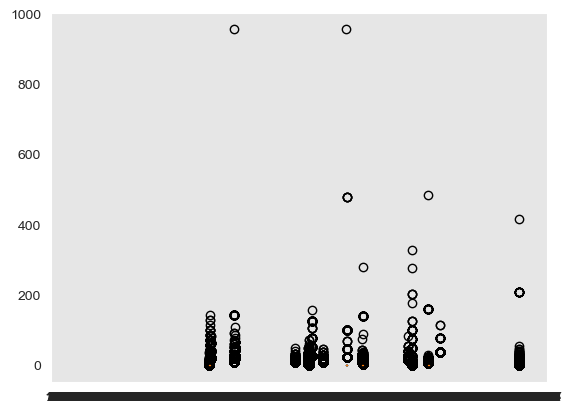

Посмотрим поближе
долго считает
plt.boxplot(data_test[list_col_num])

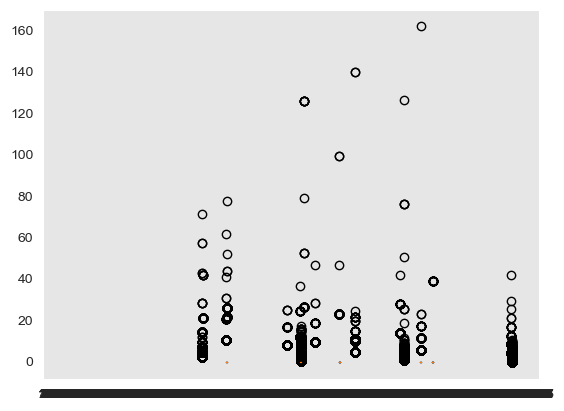

Всё-таки подозрительно выглядит, явные выбросы. По-правильному - нужно разбираться в причинах. Но мы сегодня неправильные аналитики и сделаем неправильный мёд - мы отбросим экстремальные значения.


In [106]:
#data_train = data_train[data_train[list_col_num] < 150]

In [107]:
#data_test = data_test[data_test[list_col_num] < 150]

Ещё раз посмотрим на усы

In [108]:
#долго считает
#plt.boxplot(data_train[list_col_num])

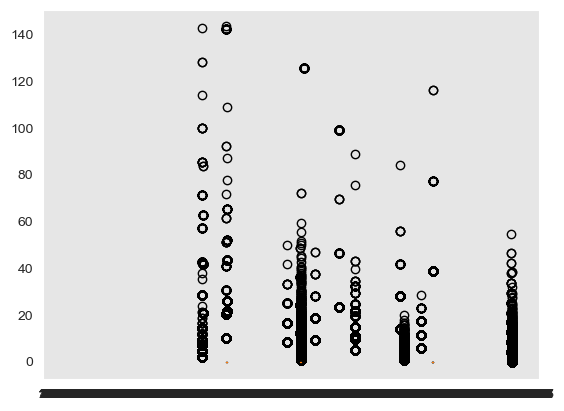

Наши минимумы он даже не отображает, оканчивается всё где-то на 0

In [109]:
#data_train = data_train[data_train[list_col_num] > -200]

In [110]:
#data_train[list_col_num].min().min()

In [111]:
#data_train[data_train[list_col_num] < -15].count().sum()

In [112]:
#data_test[data_test[list_col_num] < -15].count().sum()

Проверили меньше -20 - мало, меньше -10 - уже тысячи,  Меньше 15 - 1632 и 53 значения соответственно. Обрезаем на -15.

In [113]:
data_train = data_train[data_train[list_col_num] > -16]
data_test = data_test[data_test[list_col_num] > -16]

In [114]:
data_test[data_test[list_col_num] > 75].count().sum()

1108

В тесте всего 550 > 85, 831 > 75, обрезаем по 75

In [115]:
data_train = data_train[data_train[list_col_num] < 75]
data_test = data_test[data_test[list_col_num] < 75]

In [116]:
add_n = data_test[list_col_num].min()
add_n

markers_0_1_cnt     -0.150
markers_1_1_cnt     -0.097
markers_2_1_cnt     -0.401
markers_3_1_cnt     -0.363
markers_4_1_cnt     -2.014
                     ...  
markers_941_1_cnt   -0.059
markers_942_1_cnt   -0.037
markers_943_1_cnt   -0.241
markers_944_1_cnt   -0.118
markers_945_1_cnt   -0.486
Length: 2607, dtype: float16

In [117]:
add_n.describe()

count   2607.000
mean      -0.646
std        1.732
min      -15.711
25%       -0.351
50%       -0.088
75%       -0.022
max        0.000
dtype: float64

In [118]:
data_test = data_test[data_test[list_col_num] < 75]

In [119]:
data_train = data_train[list_col_num] - add_n[list_col_num] + 1

In [120]:
data_test = data_test[list_col_num] - add_n[list_col_num] + 1

In [121]:
data_train[list_col_num].min()

markers_0_1_cnt     1.000
markers_1_1_cnt     1.000
markers_2_1_cnt     1.000
markers_3_1_cnt     1.000
markers_4_1_cnt     1.000
                     ... 
markers_941_1_cnt   1.000
markers_942_1_cnt   1.000
markers_943_1_cnt   1.000
markers_944_1_cnt   1.000
markers_945_1_cnt   1.000
Length: 2607, dtype: float16

In [122]:
data_test[list_col_num].min().min()

1.0

In [123]:
data_train = data_train.fillna(0)
data_test = data_test.fillna(0)

In [124]:
(data_train.isna().sum()+data_test.isna().sum()).sum()

0

In [125]:
data_train = data_train[list_col_num] + add_n[list_col_num] - 1
data_test = data_test[list_col_num] + add_n[list_col_num] - 1

Мы транспонировали все значения на величину минимума столбца плюс 1 и заполнили пропуски нулями, а потом вернули все значения на ту же величину (минимум - 1) обратно. В резултьтате у нас получилась "заглушка" из не встречающихся в датасете значений. Всё, у нас базы без пропусков, можно масштабировать. Некоторые признаки имеют сильный дисбаланс значений, из-за чего их влияние на модель может быть малозначимым.

В процессе подготовки датасета к последующим рачётам мы проверяли различные гипотезы, как скажутся на конечных показателях разные варианты заполнения пропусков и отбора признаков. Так, были отброшены, как приведшие к худшему результату, варианты с незаполнением пропусков и заполнением нулями.

В процессе отбора признаков мы пропускали их через последовательные сита заполненности данных, убирая слишком малозаполненные; нормальности распределения (с расчётом вариабельности показателя). Выбирали наиболее важные для моделей (catboost, random forest). Но все варианты, подготовленные командой уступили кропотливому ручному выбору признаков, выполненному Александрой Саакян. Она брала группу признаков, рассчитывала корреляцию с целевым признаком и убирала внутри группы признаки с мультиколлинеарностью. В результате получился датасет, показавший лучший результат. Его мы и будем использовать.

### Предварительная оценка важности признаков: Mutual info

In [126]:
def mutual_info(X: pd.DataFrame, Y: pd.DataFrame):
    
    # Label encoding for categoricals
    for column in X.select_dtypes(exclude='number'):
        X[column], _ = X[column].factorize()

    # All discrete features should have integer dtypes
    discrete_features_lst = (X.dtypes == int)             # маска (булев вектор) выделяющий дискретные признаки
    
#     m_info = mutual_info_classif(X, Y, n_neighbors=7, discrete_features=discrete_features_lst, random_state=RS)
    m_info = mutual_info_classif(X, Y, n_neighbors=7, random_state=RS)
    
    display(pd.Series(m_info, name="mutual info", index=X.columns).sort_values(ascending=False))
    return pd.Series(m_info, name="mutual info", index=X.columns).sort_values(ascending=False)

In [127]:
#data_train.info()

In [128]:
#feat_imp60 = mutual_info(data_train.tail(30000).copy(), target.tail(30000).copy())

In [129]:
#feat_imp60 = pd.DataFrame(feat_imp60).reset_index()
#feat_imp60.columns= ['1', 'mutual info']
#feat_imp60

In [130]:
#feat_imp30 = mutual_info(data_train.head(30000).copy(), target.head(30000).copy())

In [131]:
#feat_imp30 = pd.DataFrame(feat_imp30).reset_index()
#feat_imp30.columns= ['1', 'mutual info']
#feat_imp30


In [132]:
#feat_imp = feat_imp30
#feat_imp['mutual info']+= feat_imp60['mutual info']
#feat_imp['mutual info'] = feat_imp['mutual info']/2

#feat_imp.to_csv (LOCAL_PATH +'feat_imp_avg.csv', index= False )

Закомментированный код в ячейках выше считал важные признаки. Теперь их просто загрузим.

In [133]:
feat_imp_avg = pd.read_csv(LOCAL_PATH +'feat_imp_avg.csv' )
feat_imp_avg

,index,mutual info
0,campaigns_121_1_part,0.004
1,spas_symptoms_ott_33_1_cnt,0.004
2,spas_symptoms_ott_116_1_cnt,0.004
3,campaigns_134_1_part,0.004
4,campaigns_323_6_part,0.004
...,...,...
2602,traffic_details_20_1d6_sum,0.000
2603,traffic_details_22_3_std,0.000
2604,traffic_details_23_3_sum,0.000
2605,traffic_details_24_3d6_avg,0.000


In [134]:
imp_features_f = feat_imp_avg[feat_imp_avg['mutual info']> 0.001]['index'].to_list()
imp_features_f

['campaigns_121_1_part',
 'spas_symptoms_ott_33_1_cnt',
 'spas_symptoms_ott_116_1_cnt',
 'campaigns_134_1_part',
 'campaigns_323_6_part',
 'spas_symptoms_ott_26_1_cnt',
 'spas_symptoms_agr_35_1_avg',
 'campaigns_311_1_part',
 'campaigns_84_3_part',
 'campaigns_190_1_part',
 'spas_symptoms_agr_25_1_sum',
 'spas_symptoms_agr_63_3_std',
 'markers_228_1_cnt',
 'campaigns_133_1_sum',
 'markers_707_1_cnt',
 'campaigns_128_6_part',
 'markers_503_1_cnt',
 'campaigns_251_1_part',
 'campaigns_193_6_part',
 'spas_symptoms_int_156_1_cnt',
 'spas_symptoms_agr_210_6_std',
 'campaigns_285_1_part',
 'campaigns_140_3_part',
 'spas_symptoms_agr_207_3_std',
 'campaigns_71_3_part',
 'campaigns_64_1_part',
 'spas_symptoms_agr_46_12_sum',
 'spas_symptoms_agr_91_6_sum',
 'spas_symptoms_agr_208_3_sum',
 'campaigns_142_1_part',
 'markers_841_1_cnt',
 'campaigns_141_6_part',
 'markers_893_1_cnt',
 'spas_symptoms_agr_61_1_sum',
 'campaigns_287_3_part',
 'markers_834_1_cnt',
 'campaigns_163_6_part',
 'campaigns_3

In [135]:
from itertools import chain

res = list(chain(*[iter(set(imp_features_f).intersection(set(imp_features)))]))
len(res)

258

Проверили, часть элементов нашего прошлого списка входит в новый. Но скор говорит, что новый список лучше, и мы будем использовать его далее.

### Создание дополнительных признаков

In [136]:
# Функция для извлечения уникальных окончаний из столбца "Feature"
def extract_unique_ends(feature):
    parts = feature.split('_')
    if len(parts) >= 2:
        return parts[-1]
    else:
        return None

# Извлечение уникальных окончаний

def list_check(lst, sub):
    return [x for x in lst if x in  sub]

def find_part_substring(lst, sub):
  pattern = re.compile(fr'\b{sub}\b')
  return [x for x in lst if pattern.search(x)]

def group_check(dataset, category):
    feature_categories = dataset.filter(like=category).columns.tolist()
    return feature_categories

def group_corr_check(dataset, category):
    matrix = dataset[group_check(dataset, category)].corr()
    matrix = pd.DataFrame(matrix, columns = feature_categories)
    return matrix

In [137]:
def sum_cols(df, cols):
    """Функция для подсчета суммы группы столбцов датасета по списку"""
    return df.loc[:, cols].sum(axis=1)

def mean_cols(df, cols):
    """Функция для подсчета суммы группы столбцов датасета по списку"""
    return df.loc[:, cols].mean(axis=1)

def max_cols(df, cols):
    """Функция для подсчета суммы группы столбцов датасета по списку"""
    return df.loc[:, cols].max(axis=1)

In [138]:
data_train_full = data_train
data_test_full = data_test
#Если всё пошло не так
#data_train = data_train_full 
#data_test = data_test_full 

In [139]:
train_feat = data_train
test_feat = data_test

In [140]:
train_feat_col = pd.DataFrame(train_feat.columns).reset_index()
train_feat_col

,index,0
0,0,markers_0_1_cnt
1,1,markers_1_1_cnt
2,2,markers_2_1_cnt
3,3,markers_3_1_cnt
4,4,markers_4_1_cnt
...,...,...
2602,2602,markers_941_1_cnt
2603,2603,markers_942_1_cnt
2604,2604,markers_943_1_cnt
2605,2605,markers_944_1_cnt


In [141]:
unique_ends = train_feat_col[0].apply(extract_unique_ends).unique()
unique_ends

array(['cnt', 'std', 'sum', 'avg', 'sumpct', 'dt', 'num', 'mean',
       'meanpct', 'max', 'part', 'ctg', 'min'], dtype=object)

In [142]:
col_start[2]

'materials_details'

Немного посмотрели, пора готовить новые признаки перед удалением столбцов.

In [143]:
list_group_start = []
for item in col_start:
    listik  = group_check(train_feat, item)
    if len(listik)>1:
        list_group_start.append(listik)

In [144]:
len(list_group_start)

25

In [145]:
list_group_end = []
for item in col_end:
    listik_end  = group_check(train_feat, item)
    if len(listik)>1:
        list_group_end.append(listik_end)


In [146]:
for item in list_group_end:
    print(len(item))

0
1409
120
514
210
2
0
0
16
17
0
3
0
0
2


In [147]:
list_groups = []

for item_end in list_group_end:
    list_groups_tmp = []
    for starts in list_group_start:
        listik_start = list_check(item_end, starts)
        if len(listik_start)>1:
            list_groups_tmp.append(listik_start)
    list_groups.append(list_groups_tmp)



In [148]:
for item in list_groups:
    print(len(item))

0
12
3
9
8
0
0
0
4
3
0
0
0
0
0


In [149]:
def col_name(func, index):
    string1 = func+'_'+str(index)#+ '_' + str(indexJ)
    return string1

In [150]:
train_feat.columns

Index(['markers_0_1_cnt', 'markers_1_1_cnt', 'markers_2_1_cnt',
       'markers_3_1_cnt', 'markers_4_1_cnt', 'markers_5_1_cnt',
       'markers_6_1_cnt', 'markers_7_1_cnt', 'markers_8_1_cnt',
       'markers_9_1_cnt',
       ...
       'markers_936_1_cnt', 'markers_937_1_cnt', 'markers_938_1_cnt',
       'markers_939_1_cnt', 'markers_940_1_cnt', 'markers_941_1_cnt',
       'markers_942_1_cnt', 'markers_943_1_cnt', 'markers_944_1_cnt',
       'markers_945_1_cnt'],
      dtype='object', length=2607)

Вернем список в 1 измерение.

In [151]:
list_2_dim = []
for item in list_groups:
    if len(item) > 1:
        list_2_dim.append(item)
        print(len(item))


12
3
9
8
4
3


In [152]:
list_1_dim = []
for item in list_groups:
    if len(item) > 0:
        for lst in item:
            if len(lst) > 1:
                list_1_dim.append(lst)

Мы пробовали разные варианты (заполнение средним, суммой, количеством значений, максимумом по группе). Лучшую значимость и результат показало заполнение максимумом и средним, с последующим отбором колонок.

In [153]:
for i in range(len(list_1_dim)):
            train_feat[col_name('max', i)] = max_cols(train_feat, list_1_dim[i])
            test_feat[col_name('max', i)] = max_cols(test_feat, list_1_dim[i])

In [154]:
for i in range(len(list_1_dim)):
            train_feat[col_name('mean', i)] = mean_cols(train_feat, list_1_dim[i])
            test_feat[col_name('mean', i)] = mean_cols(train_feat, list_1_dim[i])

In [155]:
train_feat.isna().sum().sum()
test_feat.isna().sum().sum()

0

In [156]:
(train_feat.columns == test_feat.columns).all()

True

Пропуски не появились, максимумы и средние значения посчитаны, время удалить лишние столбцы. Для этого развернём список просто в перечень столбцов


In [157]:
list_0_dim = []
for item in list_1_dim:
    for lst in item:
        list_0_dim.append(lst)

In [158]:
cat_imp_list = ['mean_0', 'mean_24','mean_25', 'mean_30', 'mean_32', 
                'max_13', 'max_30', 'max_32']
imp_features += cat_imp_list
len(imp_features)

739

Мы добавили в список столбцы, которые проверили на важность в модели кэтбуст. Остальное удалим.

In [159]:
list_down = [x for x in train_feat.columns if x not in imp_features]
len(list_down)


2114

In [160]:
train_feat = train_feat.drop(list_down, axis= 1)
test_feat = test_feat.drop(list_down, axis= 1)

In [161]:
test_feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60661 entries, 0 to 60660
Columns: 571 entries, markers_2_1_cnt to mean_32
dtypes: float16(571)
memory usage: 66.1 MB


In [162]:
train_feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702086 entries, 0 to 702085
Columns: 571 entries, markers_2_1_cnt to mean_32
dtypes: float16(571)
memory usage: 764.6 MB


## Логарифмирование

Кому у нас на Руси нужно логарифмирование? А давайте посмотрим... При отличии на порядок - уже можно. Посмотрим на размах крыльев.

In [163]:
log_list = (train_feat.max()-train_feat.min()).astype(float16)
log_list.reset_index()
log_list

markers_2_1_cnt      9.961
markers_16_1_cnt     9.516
markers_32_1_cnt    14.141
markers_103_1_cnt    3.941
markers_108_1_cnt   22.250
                     ...  
mean_0               7.586
mean_24              5.883
mean_25             21.922
mean_30              9.586
mean_32              6.383
Length: 571, dtype: float16

In [164]:
log_list.describe()

count   571.000
mean     19.906
std      21.641
min       1.000
25%       5.102
50%       8.617
75%      28.969
max      88.125
dtype: float64

In [165]:
log_list = log_list[log_list > 100]
log_list

Series([], dtype: float16)

In [166]:
len(log_list)

0

Все значения ниже 100, ведь мы обрезали выбросы. Логарифмирование не применяем, с этим справятся стандартные скалеры.

#data['lead_time_log'] = np.log(data.lead_time + 1).fillna(0)
#data_test['lead_time_log'] = np.log(data_test.lead_time + 1).fillna(0)
#data['lead_time_log'] = np.log(data.lead_time + 1).fillna(0)
#data_test['lead_time_log'] = np.log(data_test.lead_time + 1).fillna(0)


##  Выбор скалера

для числовых признаков нам нужно масштабирование. Балансировка классов поручена встроенным методам моделей (у кого они есть). Применение сторонней балансировки (например, SVMSMOTE) катастрофически снижает скорость обучения.

In [167]:
ss = StandardScaler()
mm = MinMaxScaler()
#rs = RobustScaler()

In [168]:
train_feat.min().min()

-16.72

In [169]:
train_feat.max().max()

74.94

In [170]:
#train_feat_scaled = ss.fit_transform(train_feat)
#train_feat_scaled = rs.fit_transform(train_feat)
train_feat_scaled = mm.fit_transform(train_feat)


In [171]:
train_feat_scaled.min().min()

0.0

In [172]:
train_feat_scaled.max().max()

1.001

In [173]:
test_feat.min().min()

-16.72

In [174]:
test_feat.max().max()

74.44

In [175]:
test_feat_scaled = mm.transform(test_feat)

In [176]:
test_feat_scaled.min().min()

0.0

In [177]:
test_feat_scaled.max().max()

2.652

In [178]:
del test_feat_scaled
del train_feat_scaled

Как мы не проверяли - лучше результат с масштабированием не стал. Приемлемо с минмакс скалером

Отмасштабировали, пора готовить оптуну

Так как optuna не работает с catboost, то в этом хакатоне используем GridSearchCV для оптимизации гиперпараметров алгоритма CatBoost. Определяем пространство параметров (parameters). В конце мы выводим лучшие найденные параметры и соответствующиe метрики  модели.

## Выделение признаков и целевой переменной

In [179]:
cat_categ = []

In [180]:
new_train_list = pd.read_csv(LOCAL_PATH+'dataset.csv').drop('target', axis = 1).columns


In [181]:
new_train_list = list(new_train_list) + cat_categ
new_train_list = list(set(new_train_list))

In [182]:
new_train = pd.read_parquet(LOCAL_PATH+'dataset_train.parquet', engine='fastparquet')

In [183]:
new_train = new_train[new_train_list]

In [184]:
new_test = pd.read_parquet(LOCAL_PATH+'features_oot.parquet', engine='fastparquet')

In [185]:
new_test = new_test[new_train_list]

In [186]:
list_test_num = [x for x in new_test.columns if x  in list_col_num]

In [187]:
new_train[list_test_num] = new_train[list_test_num].apply(lambda x: x.astype(float16))

In [188]:
new_test[list_test_num] = new_test[list_test_num].apply(lambda x: x.astype(float16))

In [189]:
new_test['channel_name'] = new_test['channel_name'].astype(int)

In [190]:
new_train['channel_name'] = new_train['channel_name'].astype(int)

In [191]:
new_train['period'] = new_train['period'] - 202200

In [192]:
new_test['period'] = new_test['period'] - 202300

In [193]:
new_test['period']

0        3
1        2
2        3
3        1
4        1
        ..
60656    3
60657    3
60658    2
60659    3
60660    3
Name: period, Length: 60661, dtype: int32

In [194]:
train_x, test_x, train_y, test_y = train_test_split(new_train, target, 
                                                    test_size=0.2, random_state=RS)

train_x, test_x, train_y, test_y = train_test_split(train_feat, target, 
                                                    test_size=0.2, random_state=RS)

In [195]:
cat_imp_add = train_feat[['mean_0', 'mean_24','mean_25', 'mean_30', 'mean_32', 
                'max_13', 'max_30', 'max_32']]#['mean_0','max_32','mean_32']]

In [196]:
train_cat = pd.merge(new_train, cat_imp_add,  how='left', left_index=True, right_index=True  )

In [197]:
cat_imp_add = test_feat[['mean_0', 'mean_24','mean_25', 'mean_30', 'mean_32', 
                'max_13', 'max_30', 'max_32']]#['mean_0','max_32','mean_32']]

In [198]:
test_cat = pd.merge(new_test, cat_imp_add,  how='left', left_index=True, right_index=True  )

In [199]:
train_cat = train_cat.drop('id', axis = 1)

In [200]:
test_cat =test_cat.drop('id', axis = 1)

In [201]:
train_x, test_x, train_y, test_y = train_test_split(train_cat, target, 
                                                    test_size=0.2, random_state=RS)

In [202]:
X_half_train, X_half_test, Y_half_train, Y_half_test = train_test_split(
    train_feat, target, test_size=0.6, random_state=RANDOM_STATE)
X_train, X_test, Y_train, Y_test = train_test_split(
    X_half_train, Y_half_train, test_size=0.2, random_state=RANDOM_STATE)

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((224667, 571), (224667, 1), (56167, 571), (56167, 1))

# Подбор моделей

## Optuna

###  Пайплайны моделей

In [203]:
# масштабирование
scal = (#'FT', 
           #ColumnTransformer([
                                      # для числовых признаков
                                      ('num', make_pipeline(ss)
                                      ))

In [204]:
pipelines_list = [Pipeline([ scal, ('DC',  DummyClassifier(random_state=RS)) ]),
                  Pipeline([ scal, ('RFC', RandomForestClassifier(random_state=RS)) ]),
                  Pipeline([ scal, ('HGBC', HistGradientBoostingClassifier(random_state=RS)) ]),
                  Pipeline([ scal, ('SGDC', SGDClassifier(random_state=RS)) ]),
                 ]



In [205]:
names_list = ['baseline: DummyClassifier', 'RandomForestClassifier',
              'HistGradientBoostingClassifier', 'SGDClassifier']

short_names_list = ['DC', 'RFC', 'HGBC', 'SGDC',]

### Объединение всех данных о моделях в датафрейм

In [206]:
models = pd.DataFrame(data={'name': names_list,
                            'short_name': short_names_list,
                            'model': pipelines_list
                           },
                     )
models

,name,short_name,model
0,baseline: DummyClassifier,DC,"((StandardScaler()), DummyClassifier(random_state=12345))"
1,RandomForestClassifier,RFC,"((StandardScaler()), RandomForestClassifier(random_state=12345))"
2,HistGradientBoostingClassifier,HGBC,"((StandardScaler()), HistGradientBoostingClassifier(random_state=12345))"
3,SGDClassifier,SGDC,"((StandardScaler()), SGDClassifier(random_state=12345))"


### Настройки для Optuna

In [207]:
def objective_DC(trial):

    params = {'DC__strategy': trial.suggest_categorical('DC__strategy', ['most_frequent', 'stratified'])}
    model.set_params(**params)
    cv_SKF = StratifiedKFold(n_splits=5)
    
    return cross_val_score(model, X_train, Y_train, scoring=SCORING, cv=cv_SKF, n_jobs=-1).mean()


In [208]:
def objective_RFC(trial):

    params = {
              'RFC__n_estimators': trial.suggest_int('RFC__n_estimators', 50, 1000, log=True),
              'RFC__max_depth': trial.suggest_int('RFC__max_depth', 1, 50),
              'RFC__class_weight': trial.suggest_categorical('RFC__class_weight', ['balanced',  None]),
             }
    model.set_params(**params)
    cv_SKF = StratifiedKFold(n_splits=5)
    
    return cross_val_score(model, X_train, Y_train, scoring=SCORING, cv=cv_SKF, n_jobs=-1).mean()

In [209]:
def objective_HGBC(trial):

    params = {
              'HGBC__max_depth': trial.suggest_int('HGBC__max_depth', 10, 100),
              'HGBC__learning_rate': trial.suggest_float('HGBC__learning_rate', 0.1, 10.0, log=True),
              'HGBC__max_iter': trial.suggest_int('HGBC__max_iter', 10, 500, log=True),
              'HGBC__l2_regularization': trial.suggest_float('HGBC__l2_regularization', 0.001, 1000),
              'HGBC__max_bins': trial.suggest_int('HGBC__max_bins', 5, 255),

             }
    model.set_params(**params)
    cv_SKF = StratifiedKFold(n_splits=5)
    
    return cross_val_score(model, X_train, Y_train, scoring=SCORING, cv=cv_SKF, n_jobs=-1).mean()

In [210]:
def objective_SGDC(trial):

    params = {
              'SGDC__loss': trial.suggest_categorical('SGDC__loss', ['hinge','log_loss','modified_huber','squared_hinge','perceptron']),
              'SGDC__penalty': trial.suggest_categorical('SGDC__penalty', ['l1', 'l2', 'elasticnet']),
              'SGDC__max_iter': trial.suggest_int('SGDC__max_iter', 5, 1000, log=True),
              'SGDC__validation_fraction': trial.suggest_float('SGDC__validation_fraction', 0.001, 0.999999),
              'SGDC__class_weight': trial.suggest_categorical('SGDC__class_weight', ['balanced', {0: 1, 1: 15}]),
             }
    model.set_params(**params)
    cv_SKF = StratifiedKFold(n_splits=5)
    
    return cross_val_score(model, X_train, Y_train, scoring=SCORING, cv=cv_SKF, n_jobs=-1).mean()

### Подбор гиперпараметров

In [211]:
for item in range(models.shape[0]):
    
    model = models.loc[item,'model']
    
    # создание объекта optuna.study
    study = optuna.create_study(
                                study_name=models.loc[item,'name'],
                                direction="maximize",
                                sampler=optuna.samplers.TPESampler(seed=RS)
                               )

    # оптимизация (подбор гиперпараметров)
    if models.loc[item,'short_name'] == 'DC':
        study.optimize(objective_DC, n_trials=10,  show_progress_bar=True, n_jobs=-1)
    elif models.loc[item,'short_name'] == 'RFC':
        study.optimize(objective_RFC, n_trials=N_TRIALS/2,  show_progress_bar=True, n_jobs=-1)
    elif models.loc[item,'short_name'] == 'HGBC':
        study.optimize(objective_HGBC, n_trials=N_TRIALS, show_progress_bar=True, n_jobs=-1)
    elif models.loc[item,'short_name'] == 'SGDC':
        study.optimize(objective_SGDC, n_trials=N_TRIALS,  show_progress_bar=True, n_jobs=-1)
    elif models.loc[item,'short_name'] == 'LSVC':
        study.optimize(objective_LSVC, n_trials=N_TRIALS,  show_progress_bar=True, n_jobs=-1)

    # извлечение и обучение лучшей модели
    model.set_params(**study.best_params).fit(X_train, Y_train)

    # сохранение результатов в таблице моделей
    models.loc[item,'model'] = model
    models.loc[item,'study'] = study
    
    print(f'{CR}{f.BOLD}{study.study_name}{f.END}{CR}')
    print(f'Количество попыток: {len(study.trials)}')
    print(f'Лучший результат: {f.BOLD}{study.best_value:0.4f}{f.END}{CR}')
    print('Комбинация гиперпараметров:')
    print(json.dumps(study.best_params, indent=1, sort_keys=True), f'{CR}')

[I 2023-10-23 23:25:42,561] A new study created in memory with name: baseline: DummyClassifier


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-10-23 23:25:53,196] Trial 1 finished with value: 0.49914405006432716 and parameters: {'DC__strategy': 'most_frequent'}. Best is trial 1 with value: 0.49914405006432716.
[I 2023-10-23 23:26:04,340] Trial 3 finished with value: 0.49914405006432716 and parameters: {'DC__strategy': 'most_frequent'}. Best is trial 1 with value: 0.49914405006432716.
[I 2023-10-23 23:26:06,398] Trial 4 finished with value: 0.49914405006432716 and parameters: {'DC__strategy': 'most_frequent'}. Best is trial 1 with value: 0.49914405006432716.
[I 2023-10-23 23:26:15,981] Trial 0 finished with value: 0.49914405006432716 and parameters: {'DC__strategy': 'stratified'}. Best is trial 1 with value: 0.49914405006432716.
[I 2023-10-23 23:26:19,114] Trial 7 finished with value: 0.49914405006432716 and parameters: {'DC__strategy': 'stratified'}. Best is trial 1 with value: 0.49914405006432716.
[I 2023-10-23 23:26:30,025] Trial 6 finished with value: 0.49914405006432716 and parameters: {'DC__strategy': 'most_frequ

[I 2023-10-23 23:26:38,269] A new study created in memory with name: RandomForestClassifier



baseline: DummyClassifier

Количество попыток: 10
Лучший результат: 0.4991

Комбинация гиперпараметров:
{
 "DC__strategy": "most_frequent"
} 



  0%|          | 0/25.0 [00:00<?, ?it/s]

[I 2023-10-23 23:34:30,641] Trial 4 finished with value: 0.6141181745777716 and parameters: {'RFC__n_estimators': 666, 'RFC__max_depth': 11, 'RFC__class_weight': 'balanced'}. Best is trial 4 with value: 0.6141181745777716.
[I 2023-10-23 23:49:39,388] Trial 0 finished with value: 0.6141181745777716 and parameters: {'RFC__n_estimators': 125, 'RFC__max_depth': 44, 'RFC__class_weight': 'balanced'}. Best is trial 4 with value: 0.6141181745777716.
[I 2023-10-23 23:49:54,279] Trial 1 finished with value: 0.6141181745777716 and parameters: {'RFC__n_estimators': 92, 'RFC__max_depth': 6, 'RFC__class_weight': 'balanced'}. Best is trial 4 with value: 0.6141181745777716.
[I 2023-10-23 23:50:25,946] Trial 3 finished with value: 0.6141181745777716 and parameters: {'RFC__n_estimators': 52, 'RFC__max_depth': 19, 'RFC__class_weight': 'balanced'}. Best is trial 4 with value: 0.6141181745777716.
[I 2023-10-23 23:58:05,491] Trial 5 finished with value: 0.6141181745777716 and parameters: {'RFC__n_estimators

[I 2023-10-24 00:29:18,001] A new study created in memory with name: HistGradientBoostingClassifier



RandomForestClassifier

Количество попыток: 25
Лучший результат: 0.6763

Комбинация гиперпараметров:
{
 "RFC__class_weight": "balanced",
 "RFC__max_depth": 8,
 "RFC__n_estimators": 96
} 



  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-24 00:32:00,588] Trial 8 finished with value: 0.5350787990216443 and parameters: {'HGBC__max_depth': 52, 'HGBC__learning_rate': 9.811112888916682, 'HGBC__max_iter': 28, 'HGBC__l2_regularization': 211.5141075432866, 'HGBC__max_bins': 33}. Best is trial 8 with value: 0.5350787990216443.
[I 2023-10-24 00:32:51,909] Trial 12 finished with value: 0.5350787990216443 and parameters: {'HGBC__max_depth': 18, 'HGBC__learning_rate': 0.46084828517513854, 'HGBC__max_iter': 10, 'HGBC__l2_regularization': 762.6587976914599, 'HGBC__max_bins': 205}. Best is trial 8 with value: 0.5350787990216443.
[I 2023-10-24 00:33:04,715] Trial 2 finished with value: 0.5350787990216443 and parameters: {'HGBC__max_depth': 15, 'HGBC__learning_rate': 0.20932605514228544, 'HGBC__max_iter': 43, 'HGBC__l2_regularization': 521.496618802523, 'HGBC__max_bins': 164}. Best is trial 8 with value: 0.5350787990216443.
[I 2023-10-24 00:33:07,901] Trial 0 finished with value: 0.5350787990216443 and parameters: {'HGBC__max

[I 2023-10-24 00:51:13,171] A new study created in memory with name: SGDClassifier



HistGradientBoostingClassifier

Количество попыток: 50
Лучший результат: 0.6908

Комбинация гиперпараметров:
{
 "HGBC__l2_regularization": 616.2180965995783,
 "HGBC__learning_rate": 0.36129074159512,
 "HGBC__max_bins": 250,
 "HGBC__max_depth": 62,
 "HGBC__max_iter": 257
} 



  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-24 00:51:53,252] Trial 1 finished with value: 0.5808056440097591 and parameters: {'SGDC__loss': 'hinge', 'SGDC__penalty': 'l2', 'SGDC__max_iter': 824, 'SGDC__validation_fraction': 0.8114664584370187, 'SGDC__class_weight': 'balanced'}. Best is trial 1 with value: 0.5808056440097591.
[I 2023-10-24 00:53:20,039] Trial 2 finished with value: 0.5808056440097591 and parameters: {'SGDC__loss': 'modified_huber', 'SGDC__penalty': 'l2', 'SGDC__max_iter': 579, 'SGDC__validation_fraction': 0.42382324483417805, 'SGDC__class_weight': {0: 1, 1: 15}}. Best is trial 1 with value: 0.5808056440097591.
[I 2023-10-24 00:53:34,438] Trial 0 finished with value: 0.5808056440097591 and parameters: {'SGDC__loss': 'log_loss', 'SGDC__penalty': 'l2', 'SGDC__max_iter': 8, 'SGDC__validation_fraction': 0.7317698864698378, 'SGDC__class_weight': 'balanced'}. Best is trial 1 with value: 0.5808056440097591.
[I 2023-10-24 00:54:04,107] Trial 8 finished with value: 0.5808056440097591 and parameters: {'SGDC__loss

**baseline: DummyClassifier**

Количество попыток: 200
Лучший результат: 0.5000

Комбинация гиперпараметров:
{
 "DC__strategy": "most_frequent"
} 

Best trial: 29. Best value: 0.639875: 100%
50/50 [17:39<00:00, 32.11s/it]

**RandomForestClassifier**

Количество попыток: 50
Лучший результат: 0.6399

Комбинация гиперпараметров:
{
 "RFC__class_weight": "balanced",
 "RFC__max_depth": 4,
 "RFC__n_estimators": 764
} 

Best trial: 24. Best value: 0.664049: 100%
200/200 [30:08<00:00, 7.71s/it]

**HistGradientBoostingClassifier**

Количество попыток: 200
Лучший результат: 0.6640

Комбинация гиперпараметров:
{
 "HGBC__l2_regularization": 536.2151125780542,
 "HGBC__learning_rate": 0.8509569763526628,
 "HGBC__max_bins": 18,
 "HGBC__max_depth": 81,
 "HGBC__max_iter": 38
} 

Best trial: 71. Best value: 0.644612: 100%
200/200 [08:54<00:00, 1.29s/it]

**SGDClassifier**

Количество попыток: 200
Лучший результат: 0.6446

Комбинация гиперпараметров:
{
 "SGDC__class_weight": null,
 "SGDC__loss": "log_loss",
 "SGDC__max_iter": 47,
 "SGDC__penalty": "elasticnet",
 "SGDC__validation_fraction": 0.8041939642887234
} 

C минмакс скалером ситуация была иной:

baseline: DummyClassifier

Количество попыток: 10
Лучший результат: 0.4994

Комбинация гиперпараметров:
{
 "DC__strategy": "stratified"
} 


RandomForestClassifier

Количество попыток: 15
Лучший результат: 0.5808

Комбинация гиперпараметров:
{
 "RFC__class_weight": null,
 "RFC__max_depth": 44,
 "RFC__n_estimators": 276
} 

HistGradientBoostingClassifier

Количество попыток: 30
Лучший результат: 0.6605

Комбинация гиперпараметров:
{
 "HGBC__l2_regularization": 576.2559888371206,
 "HGBC__learning_rate": 0.15890264764657644,
 "HGBC__max_bins": 205,
 "HGBC__max_depth": 41,
 "HGBC__max_iter": 174
} 


**SGDClassifier**

Количество попыток: 30
Лучший результат: 0.6619

Комбинация гиперпараметров:
{
 "SGDC__class_weight": null,
 "SGDC__loss": "log_loss",
 "SGDC__max_iter": 187,
 "SGDC__penalty": "elasticnet",
 "SGDC__validation_fraction": 0.17084659187999027
} 

И, наконец, с итоговым датасетом, отмасштабированным СтандартСкалером:

baseline: DummyClassifier

Количество попыток: 10
Лучший результат: 0.4994

Комбинация гиперпараметров:
{
 "DC__strategy": "stratified"
} 
RandomForestClassifier

Количество попыток: 15
Лучший результат: 0.6507

Комбинация гиперпараметров:
{
 "RFC__class_weight": "balanced",
 "RFC__max_depth": 48,
 "RFC__n_estimators": 131
} 

**HistGradientBoostingClassifier**

Количество попыток: 30
Лучший результат: **0.6627**

Комбинация гиперпараметров:
{
 "HGBC__l2_regularization": 905.9196036899104,
 "HGBC__learning_rate": 1.0566644602362694,
 "HGBC__max_bins": 173,
 "HGBC__max_depth": 36,
 "HGBC__max_iter": 421
} 

SGDClassifier

Количество попыток: 30
Лучший результат: 0.5784

Комбинация гиперпараметров:
{
 "SGDC__class_weight": "balanced",
 "SGDC__loss": "log_loss",
 "SGDC__max_iter": 9,
 "SGDC__penalty": "l1",
 "SGDC__validation_fraction": 0.07814604023328454
} 


Во всех подборах побеждает HistGradientBoostingClassifier с разной комбинацией гиперпараметров. Разброс говорит о том, что идеальные гиперпараметры мы ещё не нашли.

Количество попыток: 50
Лучший результат: 0.6908

Комбинация гиперпараметров:
{
 "HGBC__l2_regularization": 616.2180965995783,
 "HGBC__learning_rate": 0.36129074159512,
 "HGBC__max_bins": 250,
 "HGBC__max_depth": 62,
 "HGBC__max_iter": 257
} 

### Лучшая модель

In [212]:
BEST_MODEL_NAME = 'SGDClassifier'

model = models.model.values[models.name == BEST_MODEL_NAME][0]

In [213]:
model

Pipeline(steps=[('num', Pipeline(steps=[('standardscaler', StandardScaler())])),
                ('SGDC',
                 SGDClassifier(class_weight='balanced', loss='squared_hinge',
                               max_iter=5, penalty='l1', random_state=12345,
                               validation_fraction=0.921313498011858))])

### Cравнение дополнительных метрик

In [214]:
def add_model_metrics(models, X_train, Y_train, X_test, Y_test, cv=5, scoring_list=['f1']):
    '''
    Принимает датафрейм со списком моделей и их характеристиками.
    Добавляет в принятый датафрейм несколько метрик.
    
    :models: датафрейм с информацией об обученных моделях
    :X_train: обучающая выборка (признаки)
    :Y_train: обучающая выборка (целевая переменная)
    :X_test: тестовая выборка (признаки)
    :Y_test: тестовая выборка (целевая переменная)
    :scoring: метрики для оценки
    '''

    for scoring in scoring_list:
    
        # результаты моделей на обучающей выборке (усреднение на кроссвалидации)
        models[scoring + '_valid'] = models.model.apply(
                              lambda model: cross_val_score(model, X_train, Y_train, scoring=scoring, cv=cv, n_jobs=-1).mean())

        # результаты моделей на тестовой выборке (усреднение на кроссвалидации)
        models[scoring + '_test'] = models.model.apply(
                              lambda model: cross_val_score(model, X_test, Y_test, scoring=scoring, cv=cv, n_jobs=-1).mean())
    
    # ROC_AUC, коэффициент корреляции Мэтьюса, коэффициент каппа Коэна
    #models['ROC_AUC'] = models.model.apply(lambda model: roc_auc_score(Y_test, model.predict(X_test)))
    #models['matthews_coeff'] = models.model.apply(lambda model: matthews_corrcoef(Y_test, model.predict(X_test)))
    #models['cohen_kappa'] = models.model.apply(lambda model: cohen_kappa_score(Y_test, model.predict(X_test)))
    
    # оптимальные гиперпараметры
    models['best_params'] = models.study.apply(lambda model: model.best_params)
    
    return models

Проверим выбранную модель, оценив дополнительные метрики.
Заодно проверим остальные модели на большем количестве метрик.

models = add_model_metrics(models, X_train, Y_train, X_test, Y_test, cv=5, scoring_list=[SCORING,'f1','accuracy','recall'])

models.drop(['short_name','model','study','best_params'], axis=1)

models[['short_name','model','study','best_params']]

## GridSearchCV для CatBoostClassifier:


Лучшей моделью в предыдущей выборке стала HistGradientBoostingClassifier. К сожалению, optuna не работает с библиотекой catboost. А эта модель кажется очень перспективной для работы с нашим  датасетом. Подберём параметры GridSearchCV

### Подбор гиперпараметров

В грид изначально мы передаём следующие гиперпараметры для CatBoostClassifier:


Так как у нас выраженных дисбаланс в целевом признаке, мы будем попробовать следующие гиперпараметры для CatBoostClassifier:
**Bootstrap samples:** со значением “False”, чтобы CatBoostClassifier использовал все доступные данные для обучения и не брал случайные подвыборки.
Параметр **Depth:** установим низкое значение, до 4, чтобы уменьшить сложность модели и улучшить производительность на сильно несбалансированных данных.
**L2 regularization:** установим низкое значение параметра регуляризации, возможно, 1 или ниже, чтобы предотвратить переобучение.
**Max leaves:** - установим небольшое количество листьев, 4, чтобы увеличить вероятность предсказания редких классов и улучшить классификацию на несбалансированных данных.
**One-sided label smoothing:** используем этот параметр, чтобы сгладить несбалансированные метки. Гиперпараметр smoothing равен 0.9, чтобы получить лучшие результаты на несбалансированных наборах данных.
**auto_class_weight:**  пробуем варианты 'balanced_subsample', 'none', 'average_under_sampling','average_over_sampling', 'inverse_class_frequency'.



parameters = {
    'iterations': [ 800#, 1000, 1200
                  ],
    'learning_rate': [.01],

    'l2_leaf_reg': [1],
    'auto_class_weight':['none', 'inverse_class_frequency'],
    'max_depth': [3, 4],
    'leaf_estimation_method':['Gradient','Newton'],
    'subsample':[0.8,1.0],
    'use_best_model': [False, True]
}

clf = CatBoostClassifier(eval_metric='AUC')
grid_search = GridSearchCV(clf, parameters,scoring='roc_auc', verbose=1)
grid_search.fit(train_x, train_y)


print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Accuracy on test data: {grid_search.score(test_x, test_y)}")


Best hyperparameters: {'iterations': 800, 'l2_leaf_reg': 1, 'leaf_estimation_method': 'Newton', 'learning_rate': 0.01, 'max_depth': 4, 'subsample': 1.0, 'use_best_model': False}
Accuracy on test data: 0.6934707418599318

Продолжаем подбор параметров, последняя ячейка ниже, результаты подбора в описании далее.

In [215]:
parameters = {
    'iterations': [ 2400],
    'learning_rate': [.01],
    'l2_leaf_reg': [1],
    'max_depth': [4],
    'leaf_estimation_method':['Newton'],
    'subsample':[1.0],
    'use_best_model': [False],
    'early_stopping_rounds' :[50],
    'class_weights': [{0: 1, 1: 15}]
}

clf = CatBoostClassifier(eval_metric='AUC')
grid_search = GridSearchCV(clf, parameters,scoring='roc_auc', verbose=1)
grid_search.fit(train_x, train_y)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
0:	total: 267ms	remaining: 10m 39s
1:	total: 439ms	remaining: 8m 46s
2:	total: 563ms	remaining: 7m 30s
3:	total: 726ms	remaining: 7m 14s
4:	total: 857ms	remaining: 6m 50s
5:	total: 1.01s	remaining: 6m 41s
6:	total: 1.15s	remaining: 6m 32s
7:	total: 1.3s	remaining: 6m 29s
8:	total: 1.4s	remaining: 6m 11s
9:	total: 1.52s	remaining: 6m 4s
10:	total: 1.67s	remaining: 6m 3s
11:	total: 1.8s	remaining: 5m 58s
12:	total: 1.93s	remaining: 5m 53s
13:	total: 2.06s	remaining: 5m 51s
14:	total: 2.19s	remaining: 5m 47s
15:	total: 2.34s	remaining: 5m 48s
16:	total: 2.5s	remaining: 5m 51s
17:	total: 2.64s	remaining: 5m 48s
18:	total: 2.75s	remaining: 5m 45s
19:	total: 2.92s	remaining: 5m 47s
20:	total: 3.07s	remaining: 5m 47s
21:	total: 3.19s	remaining: 5m 45s
22:	total: 3.35s	remaining: 5m 46s
23:	total: 3.5s	remaining: 5m 46s
24:	total: 3.66s	remaining: 5m 47s
25:	total: 3.78s	remaining: 5m 45s
26:	total: 3.89s	remaining: 5m 41s
27:	total: 4

GridSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x0000011C1AD3D390>,
             param_grid={'class_weights': [{0: 1, 1: 15}],
                         'early_stopping_rounds': [50], 'iterations': [2400],
                         'l2_leaf_reg': [1],
                         'leaf_estimation_method': ['Newton'],
                         'learning_rate': [0.01], 'max_depth': [4],
                         'subsample': [1.0], 'use_best_model': [False]},
             scoring='roc_auc', verbose=1)

In [216]:
print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Auc roc on test data: {grid_search.score(test_x, test_y)}")


Best hyperparameters: {'class_weights': {0: 1, 1: 15}, 'early_stopping_rounds': 50, 'iterations': 2400, 'l2_leaf_reg': 1, 'leaf_estimation_method': 'Newton', 'learning_rate': 0.01, 'max_depth': 4, 'subsample': 1.0, 'use_best_model': False}
Auc roc on test data: 0.7578757420425716


Мы проверяли разный набор гиперпараметров в сетке грид. Первым победителем стал:

Best hyperparameters: {'iterations': 1000, 'l2_leaf_reg': 1, 'leaf_estimation_method': 'Newton', 'learning_rate': 0.01, 'max_depth': 4, 'subsample': 1.0, 'use_best_model': False}
Auc roc on test data: 0.747919033146075 / на Kaggle - 0.6447

Затем:

Best hyperparameters: {'early_stopping_rounds': 100, 'iterations': 2000, 'l2_leaf_reg': 1, 'leaf_estimation_method': 'Newton', 'learning_rate': 0.01, 'max_depth': 4, 'subsample': 1.0, 'use_best_model': False}
Auc roc on test data: 0.751932979114605 / на Kaggle - 0.6447

Дальнейшее повышение итераций не привело к увеличению метрики. Пробовали 'iterations': [ 2000, 3000, 5000 ]. Уменьшение 'learning_rate': [.01, 0.001] тоже. А вот увеличение веса позитивного класса добавило ещё.

Best hyperparameters: {'class_weights': {0: 1, 1: 12}, 'early_stopping_rounds': 100, 'iterations': 2000, 'l2_leaf_reg': 1, 'leaf_estimation_method': 'Newton', 'learning_rate': 0.01, 'max_depth': 4, 'subsample': 1.0, 'use_best_model': False}
Auc roc on test data: 0.7573064256536954 / на Kaggle - 0.6556

Best hyperparameters: {'class_weights': {0: 1, 1: 15}, 'early_stopping_rounds': 100, 'iterations': 2400, 'l2_leaf_reg': 1, 'leaf_estimation_method': 'Newton', 'learning_rate': 0.01, 'max_depth': 4, 'subsample': 1.0, 'use_best_model': False}
Auc roc on test data: 0.7566595589996634 / на Kaggle - 0.6556

Затем мы проверили leaf_estimation_method':['Newton', 'Gaussian','Laplace', 'AbsoluteDeviation'], 'iterations': [ 2400, 3510],  'class_weights': [{0: 1, 1: 15},{0: 1, 1: 12}]:

Best hyperparameters: {'class_weights': {0: 1, 1: 15}, 'early_stopping_rounds': 50, 'iterations': 2400, 'l2_leaf_reg': 1, 'leaf_estimation_method': 'Newton', 'learning_rate': 0.01, 'max_depth': 4, 'subsample': 1.0, 'use_best_model': False}
Auc roc on test data: 0.7583900580586124 / на Kaggle - 0.6532 открытая часть и 0.6727 скрытая.

Для проверки ещё одной гипотезы сформируем список категориальных переменных. Мы помним, что часть признаков числились категориальными, хотя и выражены числом. В нашем датасете не было ни одного категориального признака. Мы попробовали добавить их, но при добавлении, каков бы ни был метод подбора, метрики ухудшались. Поэтому мы вернулись к лучшей версии датасета, удалив этот блок кода.

С категориальными признаками попробовали сделать комбо ещё раз. Средне категориальных признаков, немного категориальных признаков. 3 категориальных признака, самых лучших, марочных. Увы! все они ухудшали показатели. С добавкой категориальных признаков cat_categ пришлось распрощаться.

Так как усиление позитивного класса давало положительный эффект, ещё раз сравнили рахные веса классов 'class_weights': [{0: 1, 1: 15},{0: 1, 1: 18}

Best hyperparameters: {'class_weights': {0: 1, 1: 18}, 'early_stopping_rounds': 50, 'iterations': 2400, 'l2_leaf_reg': 1, 'leaf_estimation_method': 'Newton', 'learning_rate': 0.01, 'max_depth': 4, 'subsample': 1.0, 'use_best_model': False}
Auc roc on test data: 0.7586213670638383 / на Kaggle - 0.6544 открытая часть и  скрытая 0.6703

Мы наблюдали это и у других участников, в ряде случаев большие показатели на открытой части теста не давали сопоставимого прироста на скрытой части. 

Best hyperparameters: {'class_weights': {0: 1, 1: 15}, 'early_stopping_rounds': 50, 'iterations': 2400, 'l2_leaf_reg': 1, 'leaf_estimation_method': 'Newton', 'learning_rate': 0.01, 'max_depth': 4, 'subsample': 1.0, 'use_best_model': False}
Auc roc on test data: 0.7639747583982911 / на Kaggle - 0.6585 открытая часть и скрытая 0.6742

Best hyperparameters: {'class_weights': {0: 1, 1: 15}, 'early_stopping_rounds': 50, 'iterations': 2400, 'l2_leaf_reg': 1, 'leaf_estimation_method': 'Newton', 'learning_rate': 0.01, 'max_depth': 4, 'subsample': 1.0, 'use_best_model': False}
Auc roc on test data: 0.757404415422636/ на Kaggle - 0.654 открытая часть и скрытая 0.6733

In [217]:
# Получим лучший классификатор из объекта GridSearchCV
best_model = grid_search.best_estimator_

In [218]:
best_model.fit(train_cat, target)

0:	total: 240ms	remaining: 9m 35s
1:	total: 461ms	remaining: 9m 12s
2:	total: 665ms	remaining: 8m 51s
3:	total: 954ms	remaining: 9m 31s
4:	total: 1.16s	remaining: 9m 15s
5:	total: 1.31s	remaining: 8m 44s
6:	total: 1.49s	remaining: 8m 29s
7:	total: 1.71s	remaining: 8m 32s
8:	total: 1.93s	remaining: 8m 31s
9:	total: 2.1s	remaining: 8m 21s
10:	total: 2.32s	remaining: 8m 23s
11:	total: 2.52s	remaining: 8m 22s
12:	total: 2.73s	remaining: 8m 20s
13:	total: 2.9s	remaining: 8m 13s
14:	total: 3.08s	remaining: 8m 9s
15:	total: 3.29s	remaining: 8m 10s
16:	total: 3.5s	remaining: 8m 10s
17:	total: 3.67s	remaining: 8m 5s
18:	total: 3.87s	remaining: 8m 5s
19:	total: 4.07s	remaining: 8m 4s
20:	total: 4.34s	remaining: 8m 12s
21:	total: 4.58s	remaining: 8m 15s
22:	total: 4.76s	remaining: 8m 12s
23:	total: 4.94s	remaining: 8m 8s
24:	total: 5.13s	remaining: 8m 7s
25:	total: 5.36s	remaining: 8m 9s
26:	total: 5.6s	remaining: 8m 11s
27:	total: 5.82s	remaining: 8m 13s
28:	total: 6.08s	remaining: 8m 17s
29:	to

In [219]:
test_y_cat = best_model.predict(test_cat)

In [220]:
# Вычислим вероятности принадлежности целевому классу 
proba_cat = best_model.predict_proba(test_cat)[:, 1]
# Создаем DataFrame с колонками 'id' и 'target' (вероятности)
results_cat = pd.DataFrame({'id':test_feat.index, 'target': proba_cat})

In [221]:
# Сохраняем результаты в CSV-файл
results_cat.to_csv(LOCAL_PATH + 'results_cat_17.csv', index=False)

In [222]:
cat_imp = pd.Series(best_model.feature_importances_, train_cat.columns)

In [223]:
cat_imp_max = cat_imp[cat_imp> 0.3].round(3)
cat_imp_max = pd.DataFrame(cat_imp_max)



Text(0.5, 1.0, 'Важность признаков Catboost ')

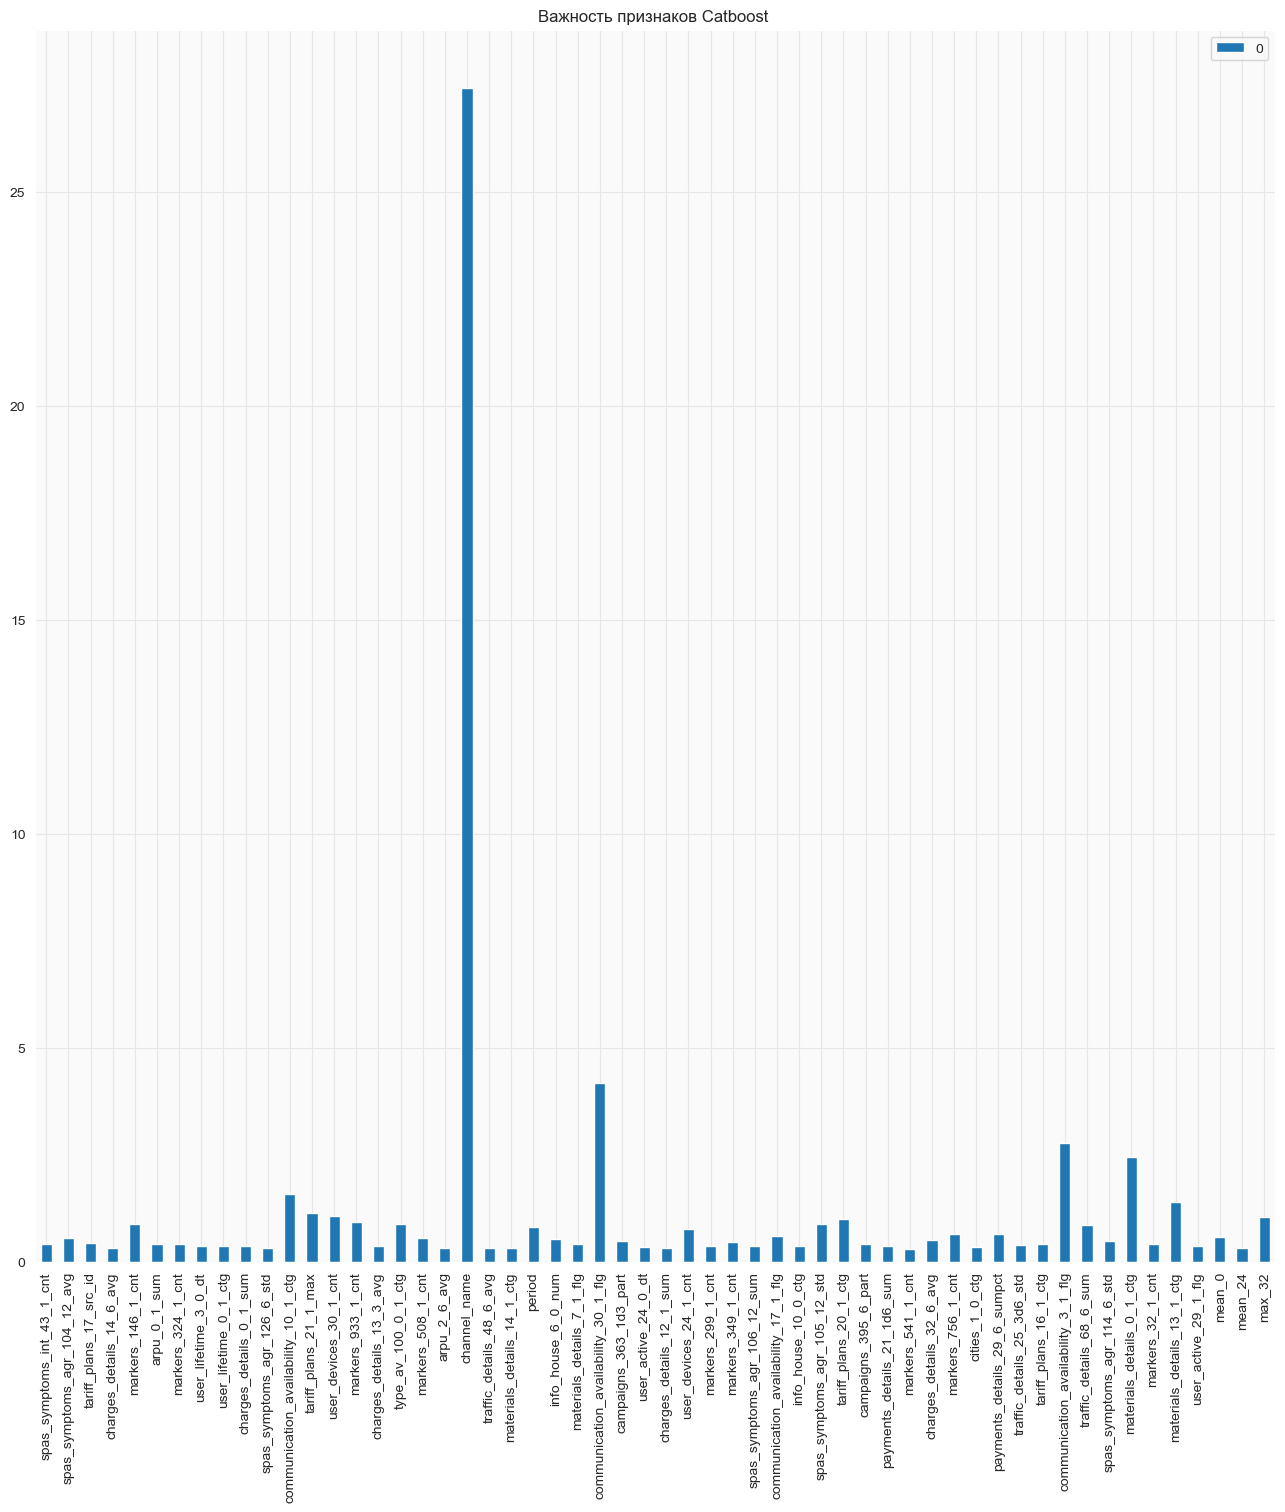

In [224]:
cat_imp_max.plot.bar(figsize=(16,16)).set_title("Важность признаков Catboost ")

In [225]:
cat_imp_max = cat_imp_max.reset_index()
cat_imp_max.sort_values(by = 0,ascending = False)

,index,0
19,channel_name,27.417
25,communication_availability_30_1_flg,4.172
46,communication_availability_3_1_flg,2.766
49,materials_details_0_1_ctg,2.451
11,communication_availability_10_1_ctg,1.582
51,materials_details_13_1_ctg,1.400
12,tariff_plans_21_1_max,1.134
13,user_devices_30_1_cnt,1.075
55,max_32,1.040
36,tariff_plans_20_1_ctg,0.986


Все еще ведется подбор признаков. Из подсчитанных нами максимумов и средних в итоговый сет вошли только одно среднее и один расчетный максимум. Столбец mean_0 с важностью для кэтбуста	1.859 и столбец mean_32	с важностью 1.149. Их использование повышает точность предсказания. Дополнительные признаки добавили десяток промилле и ещё пятьдесят - ручная балансировка (добавление весов классов).

Сейчас выполнен повторный пересчет в сопоставимых условиях с повышением важности позитивного класса целевого признака. Далее была выполнена дополнительная работа с признаками (например, период)

Попробуем взять данные за последние полгода, поскольку заказчик на совещании упоминал о важности этого периода и есть прерывание данных по разным каналам. Результат снизил данные метрик. Продолжим поиски дальше.

Попробуем убрать неважные для кэтбуста признаки, сосредоточиться на важном, так сказать.

In [226]:
cat_imp_min = cat_imp[cat_imp< 0.0001]
cat_imp_min = pd.DataFrame(cat_imp_min)
cat_imp_min = cat_imp_min.reset_index()
cat_imp_min.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   43 non-null     object 
 1   0       43 non-null     float64
dtypes: float64(1), object(1)
memory usage: 820.0+ bytes


In [227]:
cat_imp_min = cat_imp_min['index'].tolist()

In [228]:
cat_imp_min

['deact_react_12_1_ctg',
 'spas_symptoms_agr_267_3_std',
 'spas_symptoms_agr_190_12_sum',
 'user_active_19_1_flg',
 'spas_symptoms_agr_253_1_sum',
 'communication_availability_22_1_flg',
 'deact_react_2_1_ctg',
 'user_active_32_1_flg',
 'spas_symptoms_int_14_1_cnt',
 'spas_symptoms_iptv_5_1_cnt',
 'spas_symptoms_int_10_1_cnt',
 'scheme_types_4_1_flg',
 'tariff_plans_25_1_ctg',
 'spas_symptoms_agr_263_1_avg',
 'autopay_0_0_ctg',
 'spas_symptoms_agr_51_3_std',
 'spas_symptoms_int_98_1_cnt',
 'payments_details_40_3_sum',
 'spas_symptoms_ott_54_1_cnt',
 'spas_symptoms_iptv_15_1_cnt',
 'spas_symptoms_int_21_1_cnt',
 'autopay_1_1_flg',
 'communication_availability_24_1_flg',
 'communication_availability_65_1_flg',
 'spas_symptoms_int_135_1_cnt',
 'spas_symptoms_agr_42_6_std',
 'campaigns_113_1_sum',
 'spas_symptoms_int_52_1_cnt',
 'user_active_4_1_flg',
 'spas_symptoms_int_34_1_cnt',
 'deact_react_13_1_ctg',
 'communication_availability_59_1_flg',
 'user_active_16_1_flg',
 'spas_symptoms_ott

Нет, и этот эксперимент был неудачным - после удаления неважных признаков метрики ухудшились, пусть и  незначительно. Принимаем текущий вариант модели CatBoost наилучшим и переходим к сравнению с HistGradientBoostingClassifier.

## Кросс-валидация моделей-победителей

Итак, у нас 2 победителя, CatBoostClassifier и HistGradientBoostingClassifier, полученные в разных условиях. Нам нужно их сравнить, чтобы выбрать итоговую лучшую модель.

Проведем кросс-валидацию и оценку модели на тренировочных данных, чтобы убедиться в оптимальности гиперпараметров и точности модели.

In [229]:
for key in sorted(best_model.get_params().keys()):
    print("{}: {}".format(key, best_model.get_params()[key]))

class_weights: {0: 1, 1: 15}
early_stopping_rounds: 50
eval_metric: AUC
iterations: 2400
l2_leaf_reg: 1
leaf_estimation_method: Newton
learning_rate: 0.01
max_depth: 4
subsample: 1.0
use_best_model: False


In [230]:
auc_cat_train =  cross_val_score(best_model, train_feat, target, cv=5, scoring = 'roc_auc').mean()
print("auc roc градиентного бустинга с CatBoost на обучении:", auc_cat_train)


0:	total: 138ms	remaining: 5m 31s
1:	total: 262ms	remaining: 5m 14s
2:	total: 390ms	remaining: 5m 11s
3:	total: 530ms	remaining: 5m 17s
4:	total: 659ms	remaining: 5m 15s
5:	total: 775ms	remaining: 5m 9s
6:	total: 896ms	remaining: 5m 6s
7:	total: 1.04s	remaining: 5m 11s
8:	total: 1.19s	remaining: 5m 16s
9:	total: 1.31s	remaining: 5m 13s
10:	total: 1.43s	remaining: 5m 11s
11:	total: 1.56s	remaining: 5m 10s
12:	total: 1.69s	remaining: 5m 11s
13:	total: 1.83s	remaining: 5m 11s
14:	total: 1.97s	remaining: 5m 13s
15:	total: 2.09s	remaining: 5m 11s
16:	total: 2.24s	remaining: 5m 13s
17:	total: 2.36s	remaining: 5m 12s
18:	total: 2.49s	remaining: 5m 12s
19:	total: 2.64s	remaining: 5m 13s
20:	total: 2.76s	remaining: 5m 12s
21:	total: 2.88s	remaining: 5m 11s
22:	total: 3s	remaining: 5m 10s
23:	total: 3.14s	remaining: 5m 10s
24:	total: 3.28s	remaining: 5m 11s
25:	total: 3.42s	remaining: 5m 12s
26:	total: 3.56s	remaining: 5m 13s
27:	total: 3.71s	remaining: 5m 14s
28:	total: 3.85s	remaining: 5m 14s


auc roc градиентного бустинга с CatBoost на обучении: 0.7229733305247252

In [232]:
model_hgb_best = HistGradientBoostingClassifier(l2_regularization= 905.9196036899104, learning_rate= 1.0566644602362694,
                                                max_bins= 173, max_depth= 36, max_iter= 421,loss='log_loss', scoring='roc_auc' )

In [233]:
model_hgb_best.fit(train_feat, target)

HistGradientBoostingClassifier(l2_regularization=905.9196036899104,
                               learning_rate=1.0566644602362694, max_bins=173,
                               max_depth=36, max_iter=421, scoring='roc_auc')

In [234]:
predictions_hgb_proba = model_hgb_best.predict_proba(test_feat)

In [237]:
auc_sdg_train =  cross_val_score(model_sdg_best, train_feat, target, cv=5, scoring = 'roc_auc').mean()
print("auc roc градиентного бустинга с SGDClassifier на обучении:", auc_sdg_train)


auc roc градиентного бустинга с SGDClassifier на обучении: 0.564417542476108


HistGradientBoostingClassifier на кросс-валидации показал крайне скромный результат: 0.5644. Оптуна на трэйне смогла выжать из него гораздо больше. И победителем c болшим отрываом по счёту становится модель CatBoostClassifier со следующими параметрами:

In [245]:
for key in sorted(best_model.get_params().keys()):
    print("{}: {}".format(key, best_model.get_params()[key]))

class_weights: {0: 1, 1: 15}
early_stopping_rounds: 50
eval_metric: AUC
iterations: 2400
l2_leaf_reg: 1
leaf_estimation_method: Newton
learning_rate: 0.01
max_depth: 4
subsample: 1.0
use_best_model: False


Заключительный шаг - получение предсказаний вероятностей позитивного класса.

# Итоговые предсказания вероятностей класса

Получим предсказания вероятностей позитивного класса с моделью CatBoostClassifier и выгрузим их.

модель CatBoostClassifier

Получим лучший классификатор из объекта GridSearchCV и обучим его на полном датасете

In [241]:
best_model = grid_search.best_estimator_
best_model.fit(train_cat, target)


0:	total: 222ms	remaining: 8m 52s
1:	total: 437ms	remaining: 8m 44s
2:	total: 639ms	remaining: 8m 30s
3:	total: 928ms	remaining: 9m 15s
4:	total: 1.13s	remaining: 9m 3s
5:	total: 1.29s	remaining: 8m 35s
6:	total: 1.46s	remaining: 8m 20s
7:	total: 1.69s	remaining: 8m 23s
8:	total: 1.9s	remaining: 8m 23s
9:	total: 2.07s	remaining: 8m 14s
10:	total: 2.29s	remaining: 8m 18s
11:	total: 2.5s	remaining: 8m 16s
12:	total: 2.7s	remaining: 8m 15s
13:	total: 2.87s	remaining: 8m 9s
14:	total: 3.05s	remaining: 8m 5s
15:	total: 3.26s	remaining: 8m 5s
16:	total: 3.47s	remaining: 8m 6s
17:	total: 3.65s	remaining: 8m 2s
18:	total: 3.85s	remaining: 8m 2s
19:	total: 4.05s	remaining: 8m 2s
20:	total: 4.32s	remaining: 8m 9s
21:	total: 4.56s	remaining: 8m 12s
22:	total: 4.74s	remaining: 8m 10s
23:	total: 4.92s	remaining: 8m 7s
24:	total: 5.12s	remaining: 8m 5s
25:	total: 5.34s	remaining: 8m 7s
26:	total: 5.57s	remaining: 8m 9s
27:	total: 5.8s	remaining: 8m 11s
28:	total: 6.05s	remaining: 8m 14s
29:	total: 6

Вычислим вероятности принадлежности целевому классу

In [242]:
test_y_cat = best_model.predict(test_cat)
best_model

Оформим в соответствии с требованиями в DataFrame с колонками 'id' и 'target'

In [243]:
proba_cat = best_model.predict_proba(test_cat)[:, 1]
results_cat = pd.DataFrame({'id':test_feat.index, 'target': proba_cat})


Сохраняем результаты в CSV-файл

In [244]:
results_cat.to_csv(LOCAL_PATH + 'results_cat_fin.csv', index=False)

Отдел продаж может начинать пользоваться результатом нашей работы, для этого нужно передать им файл, и они смогут начать контактировать по третьему каналу с верхним сегментом базы -  с самыми высокими вероятностями приобретения оборудования.

# Выводы

Мы обрабатывали данные разными способами, использовали декомпозицию признаков, создание новых признаков по группам (комбинируя начало и конец названий столбцов, и пробуя максимум, сумму и среднее). Мы всей командой собирали и пересобирали признаки. Мы проверяли различные способы заполнения и выбрасывали данные с пропусками. Мы настроили пайплайны моделей для grid и optuna для подбора гиперпараметров и проверили также модели HistGradientBoostingClassifier и RandomForestClassifier. Всё разбивалось о него, о суровый итоговый счет.

Победителем по итоговому счету во время соревнования стала модель CatBoostClassifier с параметрами {'depth': 6, 'iterations': 540, 'learning_rate': 0.01}
Наилучшее ROC AUC: 0.7300728723147395
ROC AUC на тестовой выборке: 0.7525107727260294
созданная на очищенной базе. И она принесла итоговый auc roc на kaggle 0.6509.

Скрытая часть результатов принесла сюрприз - наша команда поднялась со среднего 9 из 16 места до четвёртого. И нашим лучшим результатом в соревновании  стали результаты модели, на самом деле занявшей второе место в нашем счёте, с auc roc на kaggle 0.6507 (счет на скрытой части - 0.6713

Ряд предположений мы не успели проверить, и часть из них проверяли уже по окончании соревнований. Мы обнаружили, что качество модели повышается с ростом (но не бесконечным) количества итераций и добавили в модель дополнительные параметры, главным из которых по влиянию на метрику стала балансировка классов, корректирующая недостаточные веса позитивного класса. Итогом доработки модели стал дополнительный подъем метрики на kaggle до 0.6744.

На итоговой встрече представителями компании R1 было озвучено, что достаточный для них коэффициент gini - больше трёх. Коэффициент gini нашей лучшей модели - (0.6744 х 2 - 1) = 0.3488

Было очень интересно работать в условиях, приближенных к боевым: с дедлайном в одну неделю и большим датасетом (не у всех в нашей команде он открывался целиком).

Благодарим за интересное соревнование!!!